![techCompanies](tech_salaries_analysis.jpg) 

# Introduction
In a world where a cheeseburger no longer costs a quarter, or the even more dejecting reality that less and less of the affluent can afford personal yachts, the value of the dollar has become less and more concurrently.  Less valuable, because the purchasing power of the dollar has diminished, but more valuable because it is more important than ever to squeeze each dollar out of income sources.  In order to combat this reality, and add to the wealth of knowledge surrounding potentially increasing an individual’s income, we are analyzing the tech companies salary dataset.

This dataset consists of information corresponding to individuals with technology centered careers. The data includes general demographic information about the individual, such as education level, years of experience, sex, and race.  For income data, the dataset provides values for metrics such as base salary and total yearly compensation.  Examples of company level information provided include the name of the company and position.  
We will also be merging the dataset with a dataset of current stock market statistics.  This will focus our population on United States based public companies, which in turn will create a more accurate and useful model. This dataset will allow us to analyze variables like the market cap group, a categorical grouping of companies based on the number of outstanding shares multiplied by the stock price.  Other metrics include the number of employees currently employed by the company, the revenue per employee generated, the industry of the company, the sector of the company, and debt growth year over year.

# Objectives
The purpose of our exploration is to find what variables have an impact on tech centered career salaries, how strong the impact of those variables are, and make a prediction as to what salary an individual can potentially expect based on the value of variables that have an impact on salary.  The expectations of this analysis are that variables such as years of experience, market cap group, and revenue per employee have a strong influence on predicting the salary of an individual.

# Stakeholders
As for the stakeholders of our analysis, any individual, current or potential, looking to apply for tech related positions can use our analysis to focus their job search efforts using the metrics that have been found to be most effective in predicting salary to increase their potential salary.  This analysis can be bought or funded by companies similar to LinkedIn, who have a large stake in the analysis and trends of the job market. By gaining a better understanding of the driving factors of salaries, companies can implement initiatives to attract certain markets, ultimately contributing to the overall growth of the industry and the economy at large. 

# Research Questions
The main question we want to answer is what variables can influence the salary of an individual with a technology centered career in the United States.  Finding an answer to this question will give an individual the ability to tailor career decisions in a way to increase the probability of receiving a higher level of compensation.  We expect that the most influential factors include the years of experience an individual has, the size of the company they are working in, and the revenue generated by the company.  This will be analyzed through correlation statistics throughout the data analysis process.

We would like to also answer the question of how strong of a relationship do significant variables have in predicting one’s income within technology centric careers based in the United States.  We expect years of experience to have the largest impact in predicting one’s income.  In order to test this hypothesis, we will be looking at the correlation statistics between years of experience and base salary, as well as the value of the calculated coefficient of years of experience in a multivariate linear regression model.


![processing](data_processing.png) 

In [1]:
# Import Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy, math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import scale

In [2]:
def adj_r2_score(x, y, y_pred):
    n = len(y)
    p = x.shape[1]
    r = 1 - (1 - r2_score(y, y_pred)) * ((n-1) / (n - p - 1))
    
    return r

In [3]:
# Load the dataset
df = pd.read_csv('tech_companies_salary.csv')
df.shape

(62642, 29)

In [4]:
df.head(3)

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,Doctorate_Degree,Highschool,Some_College,Race_Asian,Race_White,Race_Two_Or_More,Race_Black,Race_Hispanic,Race,Education
0,06-07-2017 11:33,Oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000,...,0,0,0,0,0,0,0,0,NaN,NaN
1,06-10-2017 17:11,eBay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0,...,0,0,0,0,0,0,0,0,NaN,NaN
2,06-11-2017 14:53,Amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000,...,0,0,0,0,0,0,0,0,NaN,NaN


In [5]:
# Number of null values in each column
df.isna().sum()

timestamp                      0
company                        5
level                        123
title                          0
totalyearlycompensation        0
location                       0
yearsofexperience              0
yearsatcompany                 0
tag                          870
basesalary                     0
stockgrantvalue                0
bonus                          0
gender                     19540
otherdetails               22508
cityid                         0
dmaid                          2
rowNumber                      0
Masters_Degree                 0
Bachelors_Degree               0
Doctorate_Degree               0
Highschool                     0
Some_College                   0
Race_Asian                     0
Race_White                     0
Race_Two_Or_More               0
Race_Black                     0
Race_Hispanic                  0
Race                       40215
Education                  32272
dtype: int64

### Dropping categorical data with null values

>Dropping the data with null values in the gender, education, company, race, tag, and level columns, cleans up the data in order to look at the relationship of these variables on salaries.  

>These values cannot be replaced without adversely affecting other category values.

In [6]:
# Remove rows with null values in subset columns
df = df.dropna(subset=['gender', 'Education', 'company', 'Race', 'tag', 'level'])
df.shape

(21515, 29)

## Function to split the location column into city and state columns.

Locations with more than 2 strings delimited by a comma will be set to null values.  These locations correspond to locations outside of the United States.

Limiting our scope of the data to within the U.S. will increase the accuracy and usefulness of our model, as well as eliminate some outliers in the data.

In [7]:
def split_location(loc):
    location = loc.split(', ')  
    if len(location) == 2:
        city = location[0]
        state = location[1]
    else:
        city = None
        state = None
    return pd.Series([city, state])

# apply function to dataframe
df[['City', 'State']] = df['location'].apply(split_location)
# Remove rows with null values in State column
df = df.dropna(subset='State')

### Verification of Categorical Values

In [8]:
df.State.unique()

array(['CA', 'WA', 'TX', 'AZ', 'NY', 'IL', 'MA', 'NC', 'VA', 'CO', 'FL',
       'WI', 'DC', 'OR', 'MI', 'MN', 'MO', 'PA', 'UT', 'NJ', 'TN', 'LA',
       'GA', 'AR', 'IA', 'OH', 'MD', 'IN', 'MT', 'RI', 'DE', 'OK', 'NV',
       'CT', 'AL', 'SC', 'KS', 'KY', 'WV', 'MS', 'ID', 'NE', 'HI', 'NH',
       'NM', 'ND', 'VT', 'WY', 'ME'], dtype=object)

In [9]:
df.Education.unique()

array(['PhD', "Bachelor's Degree", "Master's Degree", 'Some College',
       'Highschool'], dtype=object)

In [10]:
df.Race.unique()

array(['Asian', 'Two Or More', 'White', 'Hispanic', 'Black'], dtype=object)

In [11]:
df.title.unique()

array(['Software Engineer', 'Software Engineering Manager',
       'Hardware Engineer', 'Product Designer', 'Management Consultant',
       'Product Manager', 'Solution Architect', 'Sales',
       'Technical Program Manager', 'Data Scientist', 'Recruiter',
       'Mechanical Engineer', 'Business Analyst', 'Human Resources',
       'Marketing'], dtype=object)

![stocks](stocks_data.png) 

In [12]:
stocks_df = pd.read_csv('screener-stocks.csv')
stocks_df.head(3)

,Symbol,Company Name,Market Cap,Stock Price,% Change,Industry,PE Ratio,Ent. Value,MC Group,Sector,...,Oper. Margin,Pretax Margin,Profit Margin,R&D / Rev,Avg. Volume,Rel. Volume,RSI,Tax / Revenue,Rev Gr. This Q,Rev Gr. Next Q
0,FLWS,1-800-FLOWERS.COM,6.965698e+08,10.92,1.11%,Specialty Retail,NaN,7.024748e+08,Small-Cap,Consumer Discretionary,...,-2.89%,-3.39%,-3.24%,3.20%,420598.0,77.96%,59.81,-0.15%,-5.95%,-3.19%
1,VCXB,10X Capital Venture Acquisition Corp. III,1.421026e+08,10.77,NaN,Shell Companies,63.35,1.420773e+08,Micro-Cap,Financials,...,NaN,NaN,NaN,NaN,10038.0,0.12%,60.96,NaN,NaN,NaN
2,TXG,10x Genomics,4.316825e+09,36.89,1.77%,Health Information Services,NaN,4.023500e+09,Mid-Cap,Healthcare,...,-42.88%,-40.21%,-41.23%,43.69%,1403080.0,74.62%,34.24,1.02%,7.41%,8.17%


In [13]:
# Reformatting company values to uppercase representation eliminates redundant values in the tech salaries datase
# This also provides a category for a merge of both datasets
df['company'] = df['company'].apply(lambda company: company.upper())
stocks_df['company'] = stocks_df['Company Name'].apply(lambda company: company.upper())

#Removal of the reference to ticker GOOGL, in order to merge data corresponding solely on ticker symbol GOOG.
stocks_df.drop(stocks_df.loc[stocks_df['Symbol']=='GOOGL'].index, inplace=True)

### Editing Company Names
>Here we are reassigning many of the most common company names in the tech salaries dataset.

>These values are being changed to a value that aligns with the company names in the screener stock dataset.

In [14]:
df.loc[ df['company'] == 'GOOGLE', 'company'] = 'ALPHABET'
df.loc[ df['company'] == 'AMAZON', 'company'] = 'AMAZON.COM'
df.loc[ df['company'] == 'FACEBOOK', 'company'] = 'META PLATFORMS'
df.loc[ df['company'] == 'PAYPAL', 'company'] = 'PAYPAL HOLDINGS'
df.loc[ df['company'] == 'HSBC', 'company'] = 'HSBC HOLDINGS'
df.loc[ df['company'] == 'APPLE INC.', 'company'] = 'APPLE'
df.loc[ df['company'] == '2U', 'company'] = '2U, INC.'
df.loc[ df['company'] == 'ABBOTT', 'company'] = 'ABBOTT LABORATORIES'
df.loc[ df['company'] == '8X8', 'company'] = '8X8, INC.'
df.loc[ df['company'] == 'ADP', 'company'] = 'Automatic Data Processing'.upper()
df.loc[ df['company'] == 'AFFIRM', 'company'] = 'AFFIRM HOLDINGS'
df.loc[ df['company'] == 'AMD', 'company'] = 'ADVANCED MICRO DEVICES'
df.loc[ df['company'] == 'INTEL CORPORATION', 'company'] = 'INTEL'
df.loc[ df['company'] == 'IBM', 'company'] = 'INTERNATIONAL BUSINESS MACHINES'
df.loc[ df['company'] == 'CAPITAL ONE', 'company'] = 'CAPITAL ONE FINANCIAL'
df.loc[ df['company'] == 'CISCO', 'company'] = 'CISCO SYSTEMS'
df.loc[ df['company'] == 'JPMORGAN CHASE', 'company'] = 'JPMORGAN CHASE & CO.'
df.loc[ df['company'] == 'JP MORGAN CHASE', 'company'] = 'JPMORGAN CHASE & CO.'
df.loc[ df['company'] == 'JP MORGAN', 'company'] = 'JPMORGAN CHASE & CO.'
df.loc[ df['company'] == 'UBER', 'company'] = 'UBER TECHNOLOGIES'
df.loc[ df['company'] == 'GOLDMAN SACHS', 'company'] = 'THE GOLDMAN SACHS GROUP'
df.loc[ df['company'] == 'WALMART LABS', 'company'] = 'WALMART'
df.loc[ df['company'] == 'EBAY', 'company'] = 'EBAY INC.'
df.loc[ df['company'] == 'VISA', 'company'] = 'VISA INC.'
df.loc[ df['company'] == 'LYFT', 'company'] = 'LYFT, INC.'
df.loc[ df['company'] == 'SAP', 'company'] = 'SAP SE'
df.loc[ df['company'] == 'DELL', 'company'] = 'DELL TECHNOLOGIES'
df.loc[ df['company'] == 'BOEING', 'company'] = 'THE BOEING COMPANY'
df.loc[ df['company'] == 'GENERAL MOTORS', 'company'] = 'GENERAL MOTORS COMPANY'
df.loc[ df['company'] == 'T-MOBILE', 'company'] = 'T-MOBILE US'

### Initial merge of the data sets

In [15]:
agg_df = pd.merge(df, stocks_df, on="company", how="left")


counts = agg_df['company'].value_counts()
print('Top 10 companies with the most representation: \n')
print(counts.head(10))
print('\nSymbol column nulls: ' + str(agg_df['Symbol'].isna().sum()))

Top 10 companies with the most representation: 

company
AMAZON.COM                         2090
MICROSOFT                          1299
ALPHABET                           1104
META PLATFORMS                      867
APPLE                               569
ORACLE                              309
INTEL                               303
INTERNATIONAL BUSINESS MACHINES     277
CAPITAL ONE FINANCIAL               267
CISCO SYSTEMS                       262
Name: count, dtype: int64

Symbol column nulls: 5093


### Eliminating Remaining Null Values

To eliminate the remaining null values of the symbol column, the entries were researched and a symbol was manually entered into the dataset. 
> Private companies were assigned "PRIVATE"

> Public companies only traded on international exchanges were assigned "INTERNATIONAL"

> Government operated companies were left null

> Remaining ambiguous companies were left null

> Subsidiaries were assigned the ticker symbol corresponding to their respective parent company.

These categories will be dropped from our analysis to focus the scope of our population.

This dataset was then merged on the "Symbol" column to fill in missing values and the dataset was saved as final_aggregated_df.csv.

Column names were updated in order to follow a uniform naming convention.

# Import of Aggregated Dataset

In [16]:
df = pd.read_csv('final_aggregated_df.csv')
df.head(3)

,Unnamed: 0.1,Unnamed: 0,total_yearly_compensation,base_salary,bonus,company,city_id,location,state,city,...,pretax_margin,profit_margin,research_development_over_revenue,average_volume,relative_volume,rsi,tax_over_revenue,revenue_growth_this_quarter,revenue_growth_next_quarter,sex
0,5928,0,400000,210000,45000,ALPHABET,7472,"Sunnyvale, CA",CA,Sunnyvale,...,27.89%,24.01%,14.78%,22956359.0,72.27%,64.81,3.88%,16.00%,14.35%,Male
1,10063,1,136000,124000,11000,MICROSOFT,11521,"Redmond, WA",WA,Redmond,...,44.47%,36.27%,12.09%,22842031.0,72.63%,56.25,8.20%,17.27%,17.13%,Male
2,5929,2,337000,177000,36000,ALPHABET,7413,"San Bruno, CA",CA,San Bruno,...,27.89%,24.01%,14.78%,22956359.0,72.27%,64.81,3.88%,16.00%,14.35%,Male


In [17]:
df.shape

(16903, 92)

In [18]:
# drop entries with null values in the symbol column removes ambiguous and government operated companies
df = df.dropna(subset='symbol')

# drop entries where symbol is international or private
public_companies = df[(df['symbol'] != 'INTERNATIONAL') & (df['symbol'] != 'PRIVATE')]
public_companies.shape

(14208, 92)

In [19]:
# Subsetting columns to be included in analysis
public_companies = public_companies[['base_salary', 'total_yearly_compensation', 'title', 'years_of_experience', 
                                     'years_at_company', 'education', 'race', 'sex', 'mc_group', 'sector', 
                                     'industry', 'employees', 'revenue_per_employee', 'profit_per_employee',
                                     'cash_over_market_cap', 'debt_growth_year_over_year', 'rsi']]

In [20]:
public_companies.head(3)

,base_salary,total_yearly_compensation,title,years_of_experience,years_at_company,education,race,sex,mc_group,sector,industry,employees,revenue_per_employee,profit_per_employee,cash_over_market_cap,debt_growth_year_over_year,rsi
0,210000,400000,Software Engineer,5,5,PhD,Asian,Male,Mega-Cap,Communication Services,Internet Content & Information,182381.0,1685450.0,404620.0,4.54%,-5.47%,64.81
1,124000,136000,Software Engineer,3,2,Bachelor's Degree,Two Or More,Male,Mega-Cap,Technology,Software - Infrastructure,221000.0,1029787.0,373489.0,-0.23%,47.01%,56.25
2,177000,337000,Software Engineer,6,6,Bachelor's Degree,Asian,Male,Mega-Cap,Communication Services,Internet Content & Information,182381.0,1685450.0,404620.0,4.54%,-5.47%,64.81


In [21]:
public_companies.shape

(14208, 17)

![exploratory](exploratory.png) 

# Refining Variables

### In this section, we will be evaluating the variables we are using to predict base salary.  Our goal is to minimize the number of variables and maximize the effectiveness of the remaining variables.

In [22]:
#creating dataset with variables of interest
public_companies = public_companies[['base_salary', 'years_of_experience', 'employees', 'revenue_per_employee',
                                     'education', 'title', 'race', 'sex', 'mc_group', 'sector']]
public_companies.shape

(14208, 10)

>Profit per employee has a collinear relationship with revenue per employee.  Profit per employee is a function of revenue per employee and influenced by external factors like debt taken on by a company for the given year.  This makes it a less reliable predictor, therefore we are dropping it from the variables of interest.

>Years at company has a collinear relationship with years of experience, however years of experience is a more reliable metric due to its holistic nature.  It is for this reason we are dropping years at company from the variables of interest.

>RSI, or the relative strength index is a metric for evaluating if a stock is overbought or oversold.  This is a function of stock price and volume over time.  RSI is a time sensitive metric and with little direct relationship to predicting base salary, therefore we are dropping it from the dataset.

> Cash over market cap is a measure of the cash a company has on hand relative to the market cap of the stock.  The market cap is the number of outstanding shares times the stock price.  Because of the proportional property of this metric we are dropping it from the dataset in lieu of more direct variables like revenue per employee.

> Debt growth year over year is also a time sensitive metric.  Given that our dataset has entries dating back to 2016 and our stock market data is current, we have eliminated this from being a variable of interest.

In [23]:
public_companies.isna().sum()

base_salary              0
years_of_experience      0
employees               11
revenue_per_employee    32
education                0
title                    0
race                     0
sex                      0
mc_group                 0
sector                   0
dtype: int64

In [24]:
# drop nulls
public_companies = public_companies.dropna(subset=['employees', 'revenue_per_employee'])

# Data Standardization

In [25]:
# coloumns to be standardized
columns = ['base_salary', 'years_of_experience', 'employees', 'revenue_per_employee']

means = public_companies[columns].mean()
stds = public_companies[columns].std()

# Z-score standardization
for column in columns:
    public_companies[column + '_std'] = (public_companies[column] - means[column]) / stds[column]

In [26]:
public_companies.head(3)

,base_salary,years_of_experience,employees,revenue_per_employee,education,title,race,sex,mc_group,sector,base_salary_std,years_of_experience_std,employees_std,revenue_per_employee_std
0,210000,5,182381.0,1685450.0,PhD,Software Engineer,Asian,Male,Mega-Cap,Communication Services,1.204493,-0.382571,-0.307317,0.830102
1,124000,3,221000.0,1029787.0,Bachelor's Degree,Software Engineer,Two Or More,Male,Mega-Cap,Technology,-0.539148,-0.707955,-0.236781,0.104547
2,177000,6,182381.0,1685450.0,Bachelor's Degree,Software Engineer,Asian,Male,Mega-Cap,Communication Services,0.535421,-0.219880,-0.307317,0.830102


## Descriptive Statistics

In [27]:
public_companies.describe().round(2)

,base_salary,years_of_experience,employees,revenue_per_employee,base_salary_std,years_of_experience_std,employees_std,revenue_per_employee_std
count,14176.00,14176.00,14176.0,14176.00,14176.00,14176.00,14176.00,14176.00
mean,150591.92,7.35,350641.0,935310.56,-0.00,-0.00,0.00,-0.00
std,49322.07,6.15,547513.5,903671.35,1.00,1.00,1.00,1.00
min,10000.00,0.00,7.0,18387.00,-2.85,-1.20,-0.64,-1.01
25%,120000.00,3.00,29945.0,376908.00,-0.62,-0.71,-0.59,-0.62
50%,146000.00,6.00,124800.0,674122.00,-0.09,-0.22,-0.41,-0.29
75%,171000.00,10.00,221000.0,1226349.00,0.41,0.43,-0.24,0.32
max,893000.00,45.00,2100000.0,25719571.00,15.05,6.13,3.20,27.43


# Numerical Data: Summary Statistics and Visualizations

In [28]:
#Function to remove outliers based on IQR
def removeOutliersIQR(df, column):

    q1 = np.percentile(df[column], 25)
    q3 = np.percentile(df[column], 75)
    
    iqr = q3 - q1
    upperThreshold = q3 + (1.5 * iqr)
    lowerThreshold = q1 - (1.5 * iqr)
    
    df = df[(df[column] <= upperThreshold) & (df[column] >= lowerThreshold)]    
    
    return df

## Quantitative Individual Level Data

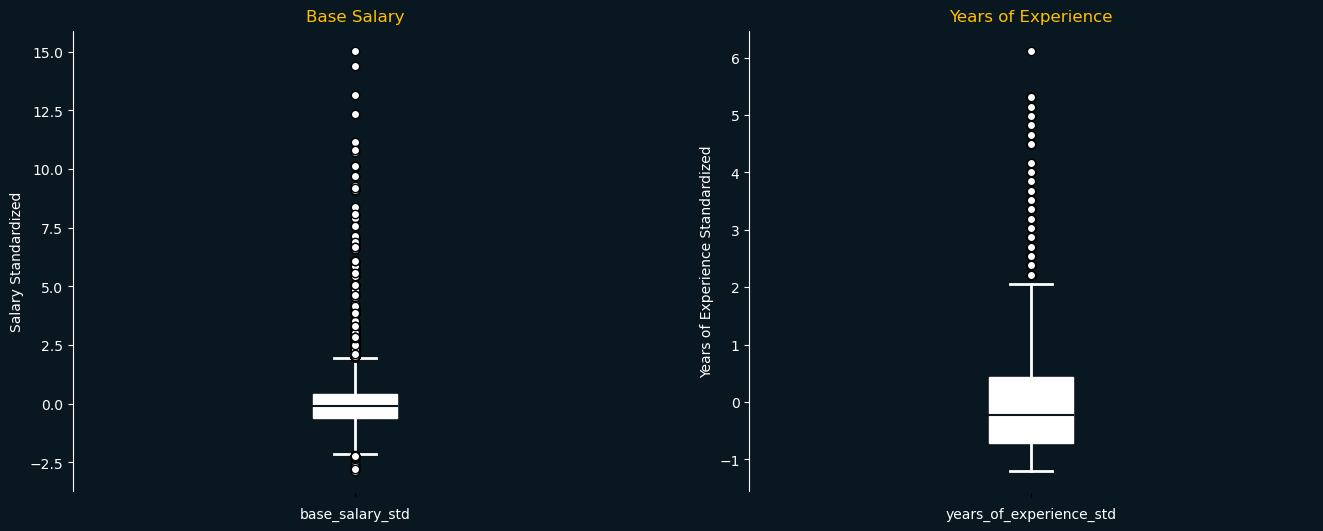

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(16)

public_companies.boxplot(column='base_salary_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[0])
ax[0].set_title('Base Salary')
ax[0].spines['bottom'].set_color('#091720')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
fig.patch.set_facecolor('#091720')
ax[0].set_facecolor('#091720')
ax[0].set_title('Base Salary', color='#FFC000')
ax[0].set_xlabel("base_salary_std", color='white')
ax[0].set_ylabel("Salary Standardized", color='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].grid(visible=False)

public_companies.boxplot(column='years_of_experience_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[1])
ax[1].set_title('Years of Experience', color='#FFC000')
ax[1].spines['bottom'].set_color('#091720')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')
ax[1].set_xlabel("years_of_experience_std", color='white')
ax[1].set_ylabel("Years of Experience Standardized", color='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].grid(visible=False)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

plt.show()

In [30]:
# remove outliers
public_companies = removeOutliersIQR(public_companies, 'base_salary_std')
public_companies = removeOutliersIQR(public_companies, 'years_of_experience_std')

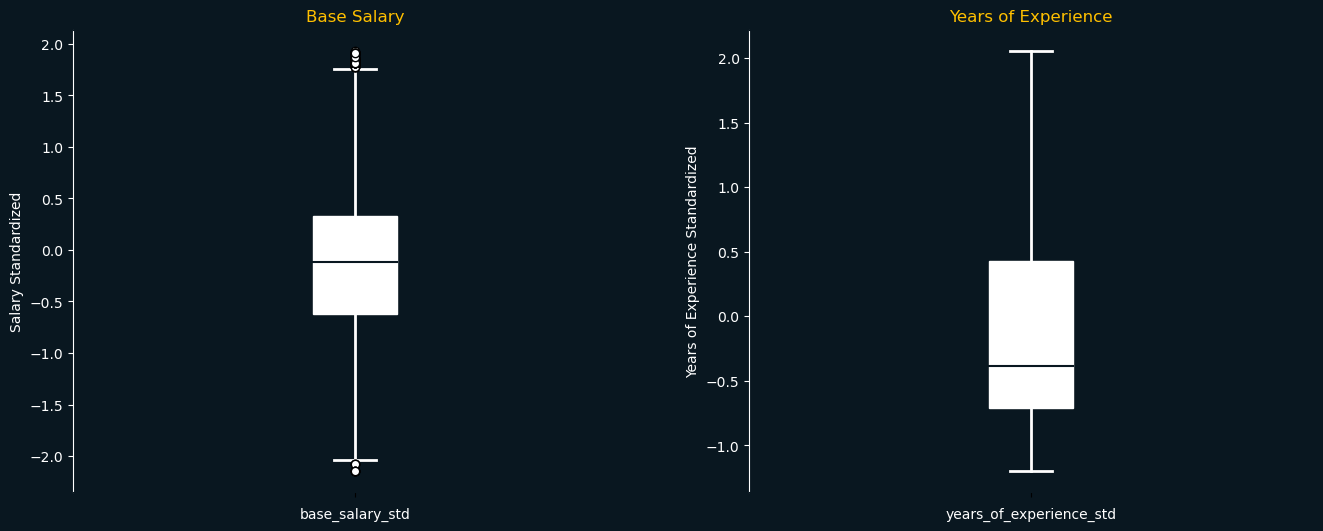

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(16)

public_companies.boxplot(column='base_salary_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[0])
ax[0].set_title('Base Salary')
ax[0].spines['bottom'].set_color('#091720')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
fig.patch.set_facecolor('#091720')
ax[0].set_facecolor('#091720')
ax[0].set_title('Base Salary', color='#FFC000')
ax[0].set_xlabel("base_salary_std", color='white')
ax[0].set_ylabel("Salary Standardized", color='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].grid(visible=False)

public_companies.boxplot(column='years_of_experience_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[1])
ax[1].set_title('Years of Experience', color='#FFC000')
ax[1].spines['bottom'].set_color('#091720')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')
ax[1].set_xlabel("years_of_experience_std", color='white')
ax[1].set_ylabel("Years of Experience Standardized", color='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].grid(visible=False)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

plt.show()

In [32]:
public_companies[['base_salary_std', 'years_of_experience_std']].describe()

,base_salary_std,years_of_experience_std
count,13383.000000,13383.000000
mean,-0.114244,-0.122651
std,0.730099,0.834791
min,-2.140865,-1.196031
25%,-0.620248,-0.707955
50%,-0.113376,-0.382571
75%,0.332672,0.430888
max,1.934389,2.057806


## Quantitative Company Level Data

In [33]:
public_companies.dropna(subset=['employees_std', 'revenue_per_employee_std'], inplace=True)

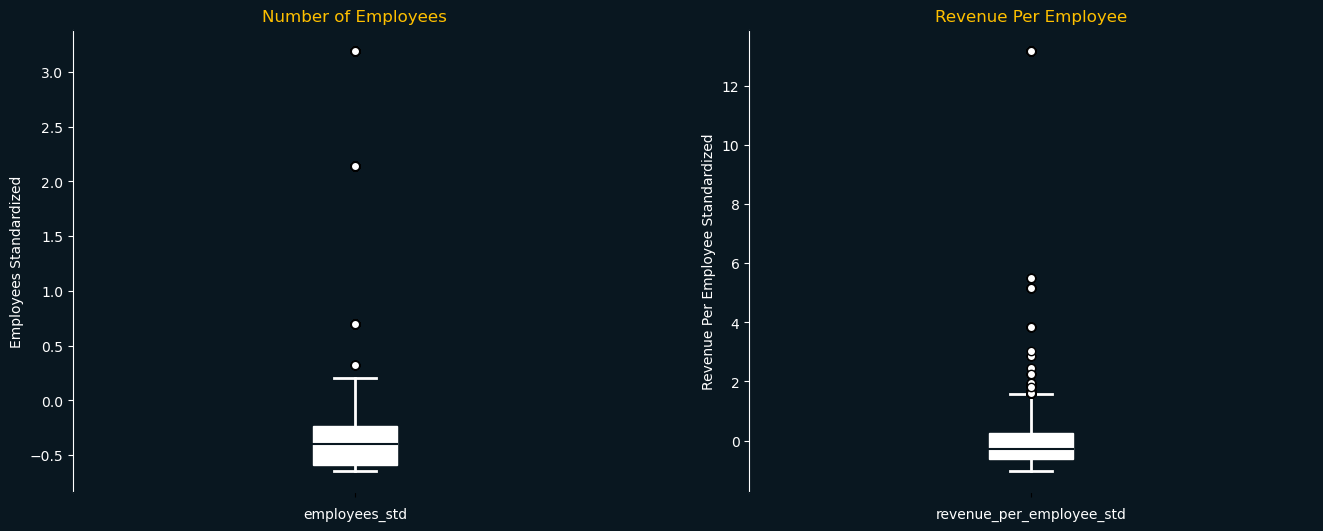

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(16)

public_companies.boxplot(column='employees_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[0])
ax[0].spines['bottom'].set_color('#091720')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
fig.patch.set_facecolor('#091720')
ax[0].set_facecolor('#091720')
ax[0].set_title('Number of Employees', color='#FFC000')
ax[0].set_xlabel("employees_std", color='white')
ax[0].set_ylabel("Employees Standardized", color='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].grid(visible=False)

public_companies.boxplot(column='revenue_per_employee_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[1])
ax[1].set_title('Revenue Per Employee', color='#FFC000')
ax[1].spines['bottom'].set_color('#091720')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')
ax[1].set_xlabel("revenue_per_employee_std", color='white')
ax[1].set_ylabel("Revenue Per Employee Standardized", color='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].grid(visible=False)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

plt.show()

In [35]:
#remove outliers
public_companies = removeOutliersIQR(public_companies, 'employees_std')
public_companies = removeOutliersIQR(public_companies, 'revenue_per_employee_std')

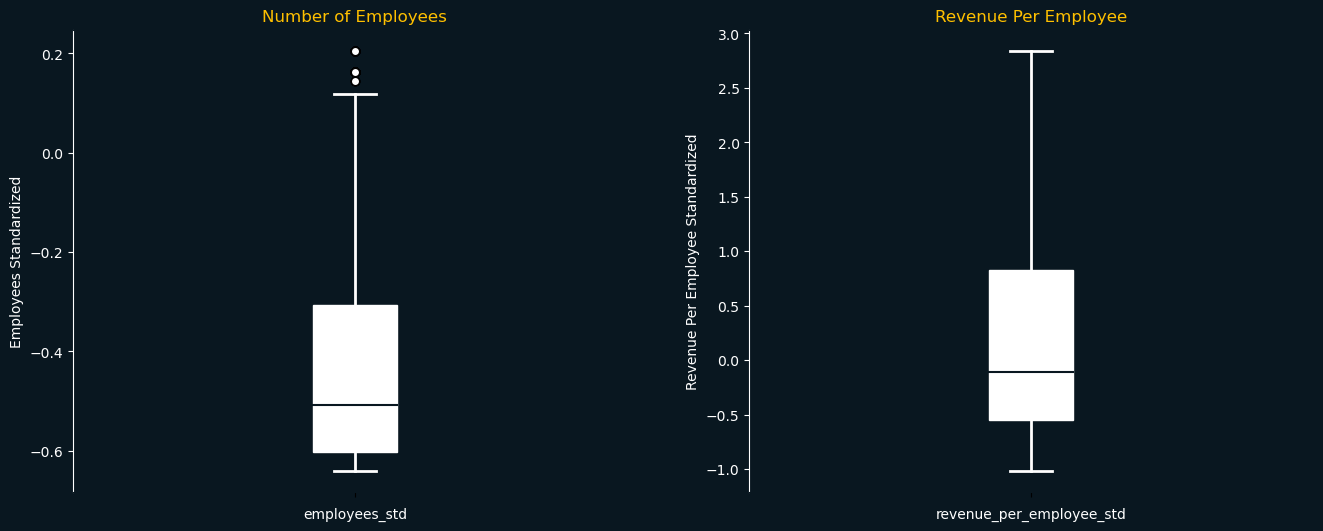

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(16)

public_companies.boxplot(column='employees_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[0])
ax[0].spines['bottom'].set_color('#091720')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
fig.patch.set_facecolor('#091720')
ax[0].set_facecolor('#091720')
ax[0].set_title('Number of Employees', color='#FFC000')
ax[0].set_xlabel("employees_std", color='white')
ax[0].set_ylabel("Employees Standardized", color='white')
ax[0].tick_params(axis='y', colors='white')
ax[0].grid(visible=False)

public_companies.boxplot(column='revenue_per_employee_std', patch_artist = True,
                         boxprops = dict(facecolor = "white", color='white'),
                         medianprops = dict(color = "#091720", linewidth = 1.5),
                         whiskerprops = dict(color = "white", linewidth = 2),
                         capprops = dict(color = "white", linewidth = 2),
                         flierprops = dict(marker = 'o', markerfacecolor = "white"), ax=ax[1])
ax[1].set_title('Revenue Per Employee', color='#FFC000')
ax[1].spines['bottom'].set_color('#091720')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')
ax[1].set_xlabel("revenue_per_employee_std", color='white')
ax[1].set_ylabel("Revenue Per Employee Standardized", color='white')
ax[1].tick_params(axis='y', colors='white')
ax[1].grid(visible=False)

ax[0].set_xticklabels([])
ax[1].set_xticklabels([])

plt.show()

In [37]:
public_companies[['employees_std', 'revenue_per_employee_std']].describe()

,employees_std,revenue_per_employee_std
count,10961.000000,10961.000000
mean,-0.440944,0.072302
std,0.171683,0.720021
min,-0.640276,-1.014665
25%,-0.603348,-0.554174
50%,-0.507675,-0.112617
75%,-0.307317,0.830102
max,0.205400,2.843103


# Categorical Data
## Individual Level

In [38]:
public_companies[['education', 'race', 'sex', 'title', 'mc_group', 'sector']].describe()

,education,race,sex,title,mc_group,sector
count,10961,10961,10961,10961,10961,10961
unique,5,5,3,15,6,11
top,Bachelor's Degree,Asian,Male,Software Engineer,Mega-Cap,Technology
freq,5293,5728,8625,6918,5587,5714


In [39]:
public_companies.groupby('mc_group')['base_salary_std'].count()

mc_group
Large-Cap    4306
Mega-Cap     5587
Micro-Cap      27
Mid-Cap       802
Nano-Cap       22
Small-Cap     217
Name: base_salary_std, dtype: int64

In [40]:
public_companies.groupby('sector')['base_salary_std'].count()

sector
Communication Services    2508
Consumer Discretionary     790
Consumer Staples            79
Energy                       8
Financials                1219
Healthcare                 185
Industrials                415
Materials                    5
Real Estate                 32
Technology                5714
Utilities                    6
Name: base_salary_std, dtype: int64

In [41]:
# removing data entries belonging to categorwith less than 30 observations
public_companies = public_companies.drop(public_companies[public_companies['mc_group'] == 'Micro-Cap'].index)
public_companies = public_companies.drop(public_companies[public_companies['mc_group'] == 'Nano-Cap'].index)

public_companies = public_companies.drop(public_companies[public_companies['sector'] == 'Energy'].index)
public_companies = public_companies.drop(public_companies[public_companies['sector'] == 'Materials'].index)
public_companies = public_companies.drop(public_companies[public_companies['sector'] == 'Utilities'].index)

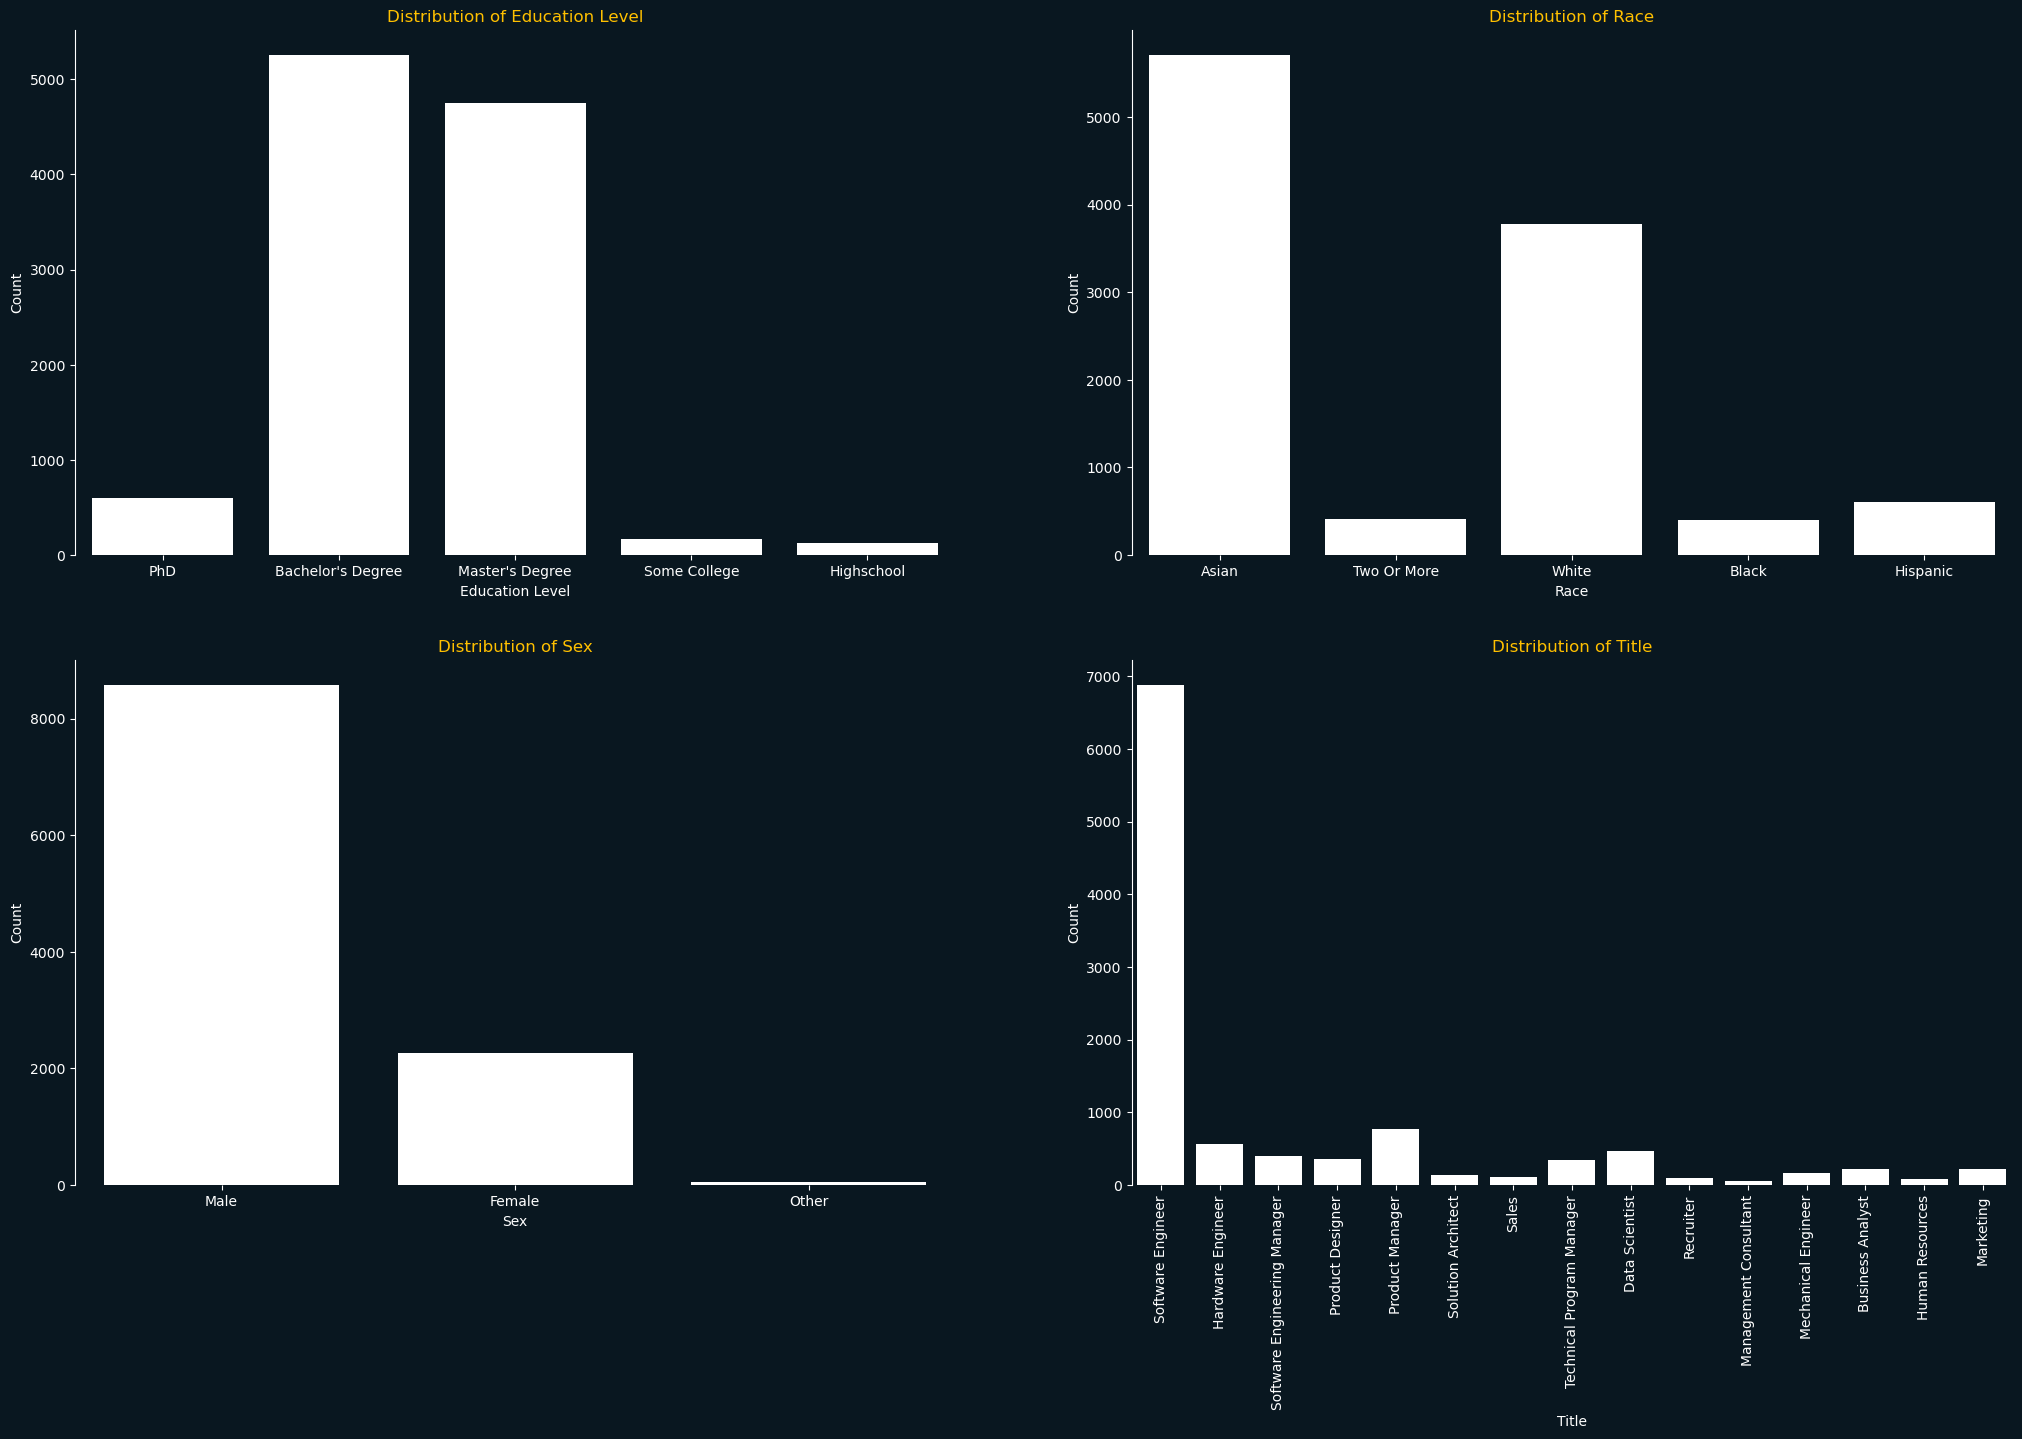

In [42]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')

sns.countplot(x='education', data=public_companies, color='white', ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Education Level', color='#FFC000')
ax[0, 0].set_ylabel('Count', color='white')
ax[0, 0].set_xlabel('Education Level', color='white')
ax[0, 0].set_facecolor('#091720')
ax[0, 0].tick_params(axis='y', colors='white')
ax[0, 0].tick_params(axis='x', colors='white')


ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['bottom'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_color('white')

sns.countplot(x='race', data=public_companies, color='white', ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Race', color='#FFC000')
ax[0, 1].set_ylabel('Count', color='white')
ax[0, 1].set_xlabel('Race', color='white')
ax[0, 1].set_facecolor('#091720')
ax[0, 1].tick_params(axis='y', colors='white')
ax[0, 1].tick_params(axis='x', colors='white')


ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['bottom'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_color('white')

sns.countplot(x='sex', data=public_companies, color='white', ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Sex', color='#FFC000')
ax[1, 0].set_ylabel('Count', color='white')
ax[1, 0].set_xlabel('Sex', color='white')
ax[1, 0].set_facecolor('#091720')
ax[1, 0].tick_params(axis='y', colors='white')
ax[1, 0].tick_params(axis='x', colors='white')


ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['bottom'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['left'].set_color('white')

sns.countplot(x='title', data=public_companies, color='white', ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Title', color='#FFC000')
ax[1, 1].set_ylabel('Count', color='white')
ax[1, 1].set_xlabel('Title', color='white')
ax[1, 1].set_facecolor('#091720')
ax[1, 1].tick_params(axis='y', colors='white')
ax[1, 1].tick_params(axis='x', colors='white')


ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines['bottom'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)
ax[1, 1].spines['left'].set_color('white')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=90)


plt.show()

## Reducing Skew

In [43]:
# removing entries with 'other' as value in sex column
public_companies = public_companies[public_companies['sex'] != 'Other']

In [44]:
# Aggregating education levels into 2 categories
education = {
    "Highschool": "bachelors_max",
    "Some College": "bachelors_max",
    "Bachelor's Degree": "bachelors_max",
    "Master's Degree": "masters_min",
    "PhD": "masters_min"}

# Replace values
public_companies['education'] = public_companies['education'].replace(education)

In [45]:
# Aggregating race categories with low representation
race = {"Black": "other",
        "Hispanic": "other",
        "Two Or More": "other"}

# Replace values
public_companies['race'] = public_companies['race'].replace(race)

In [46]:
# creating a sample of overrepresented software engineer category
titles = public_companies[public_companies['title'] == 'Software Engineer']
titles = titles.sample(400, random_state = 42)

#removing all entries with software engineer as title value
public_companies = public_companies[public_companies['title'] != 'Software Engineer']

In [47]:
# adding sampled software engineer entries back into dataset
public_companies = pd.concat([public_companies, titles], ignore_index=True)

In [48]:
# aggregating title values with low representation
title = {"Management Consultant": "other",
          "Recruiter": "other",
          "Human Resources": "other",
          'Sales': 'other',
          'Solution Architect': 'other'}

# Replace values
public_companies['title'] = public_companies['title'].replace(title)

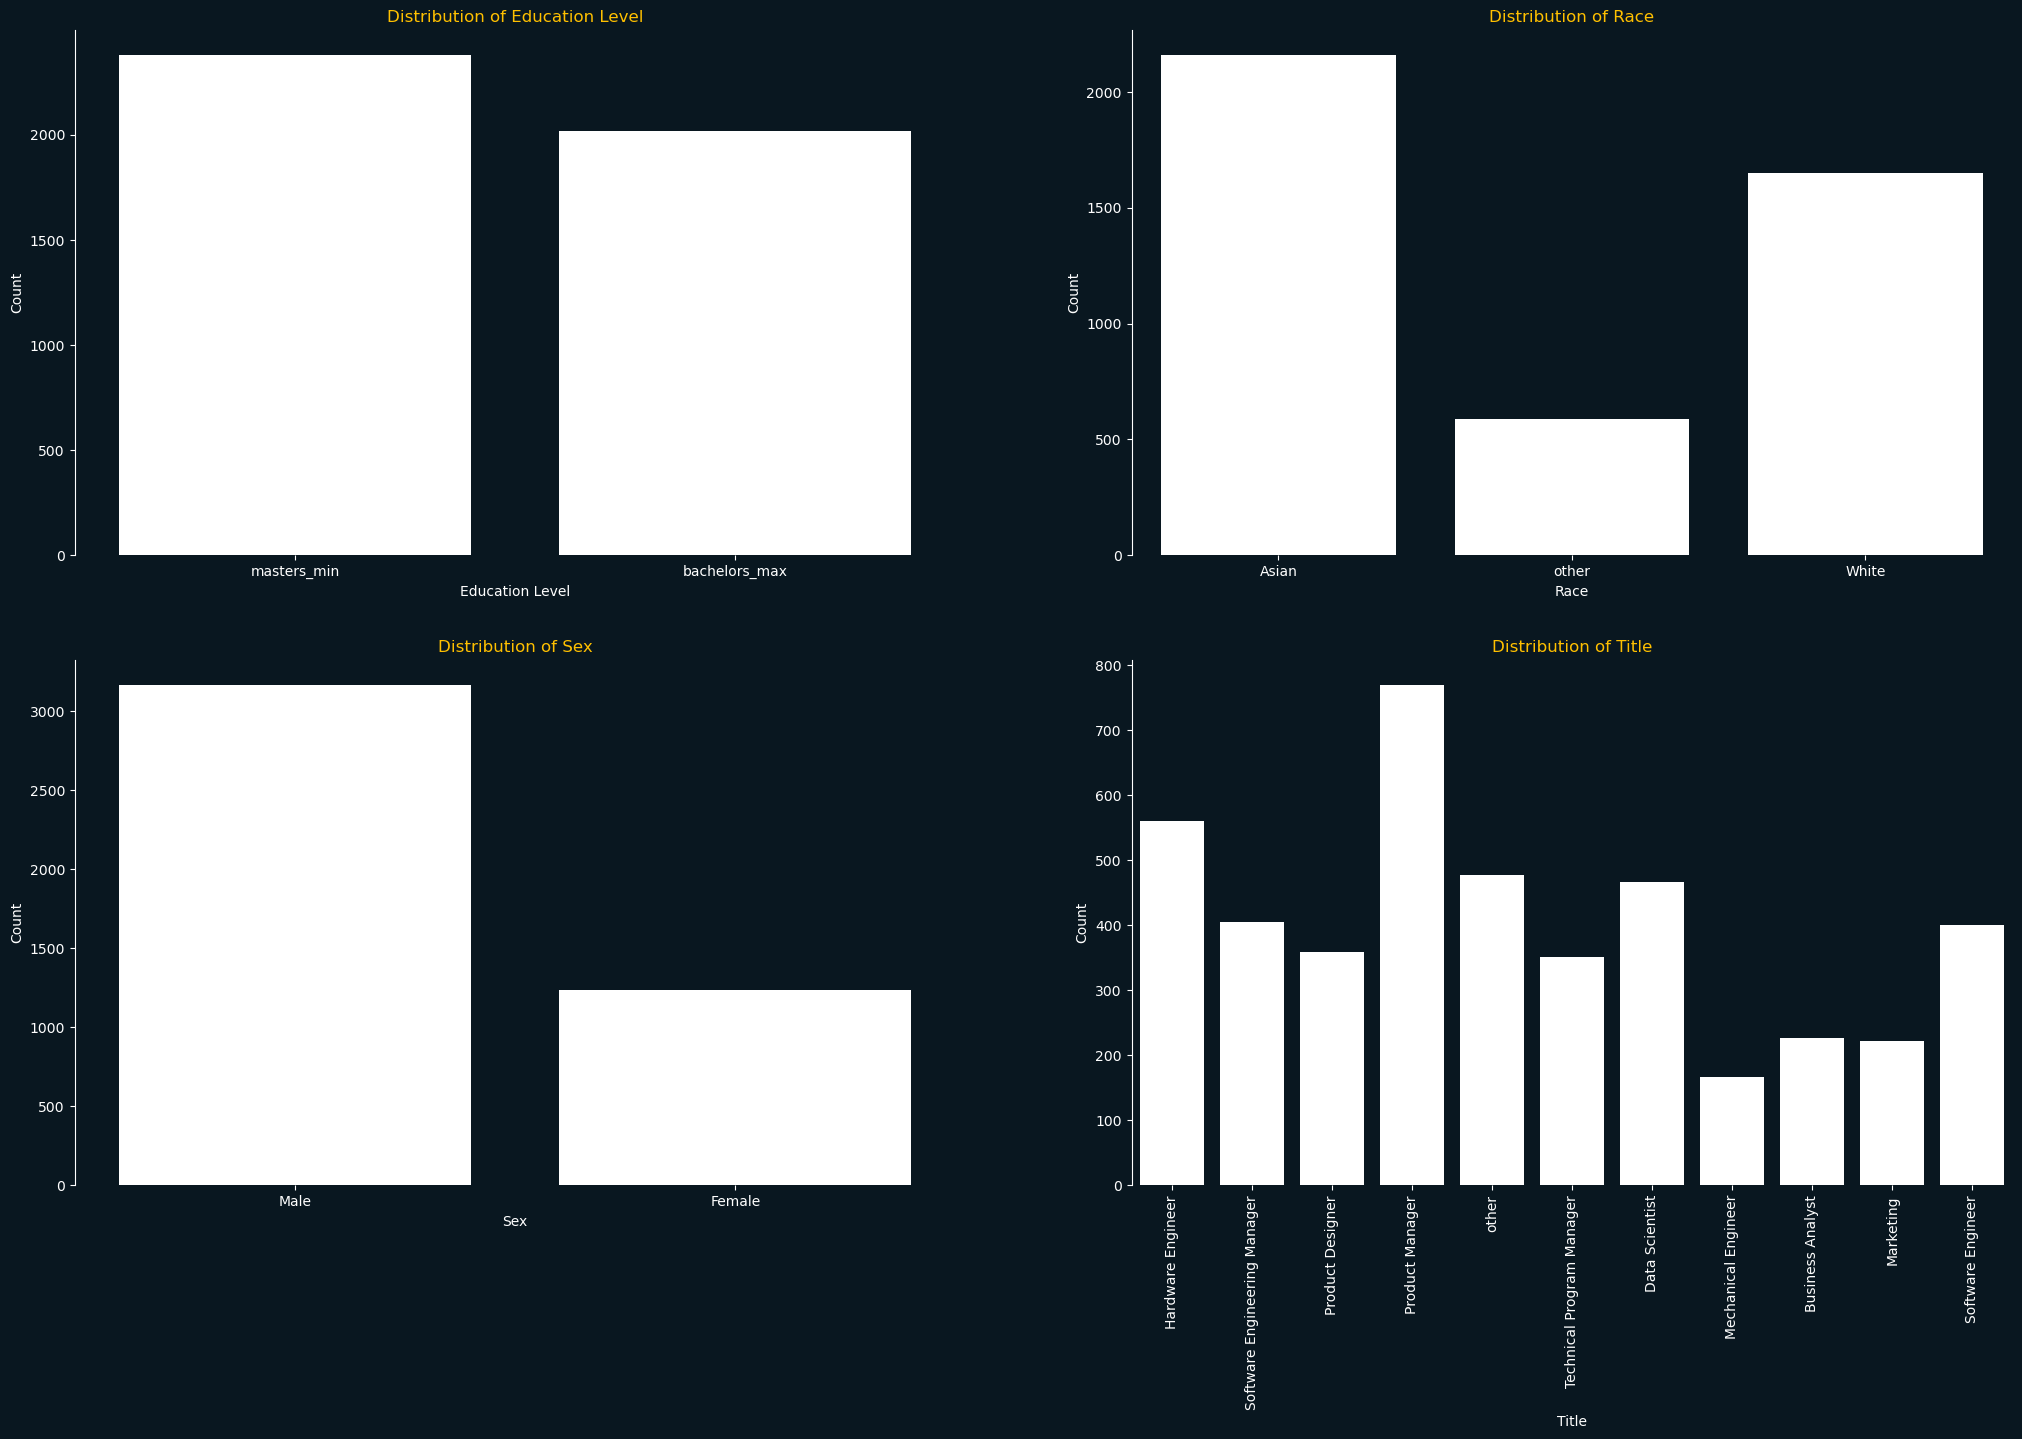

In [49]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')

sns.countplot(x='education', data=public_companies, color='white', ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Education Level', color='#FFC000')
ax[0, 0].set_ylabel('Count', color='white')
ax[0, 0].set_xlabel('Education Level', color='white')
ax[0, 0].set_facecolor('#091720')
ax[0, 0].tick_params(axis='y', colors='white')
ax[0, 0].tick_params(axis='x', colors='white')


ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['bottom'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_color('white')

sns.countplot(x='race', data=public_companies, color='white', ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Race', color='#FFC000')
ax[0, 1].set_ylabel('Count', color='white')
ax[0, 1].set_xlabel('Race', color='white')
ax[0, 1].set_facecolor('#091720')
ax[0, 1].tick_params(axis='y', colors='white')
ax[0, 1].tick_params(axis='x', colors='white')


ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['bottom'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_color('white')

sns.countplot(x='sex', data=public_companies, color='white', ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Sex', color='#FFC000')
ax[1, 0].set_ylabel('Count', color='white')
ax[1, 0].set_xlabel('Sex', color='white')
ax[1, 0].set_facecolor('#091720')
ax[1, 0].tick_params(axis='y', colors='white')
ax[1, 0].tick_params(axis='x', colors='white')


ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['bottom'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['left'].set_color('white')

sns.countplot(x='title', data=public_companies, color='white', ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Title', color='#FFC000')
ax[1, 1].set_ylabel('Count', color='white')
ax[1, 1].set_xlabel('Title', color='white')
ax[1, 1].set_facecolor('#091720')
ax[1, 1].tick_params(axis='y', colors='white')
ax[1, 1].tick_params(axis='x', colors='white')


ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines['bottom'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)
ax[1, 1].spines['left'].set_color('white')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=90)


plt.show()

# Categorical Data
## Company Level

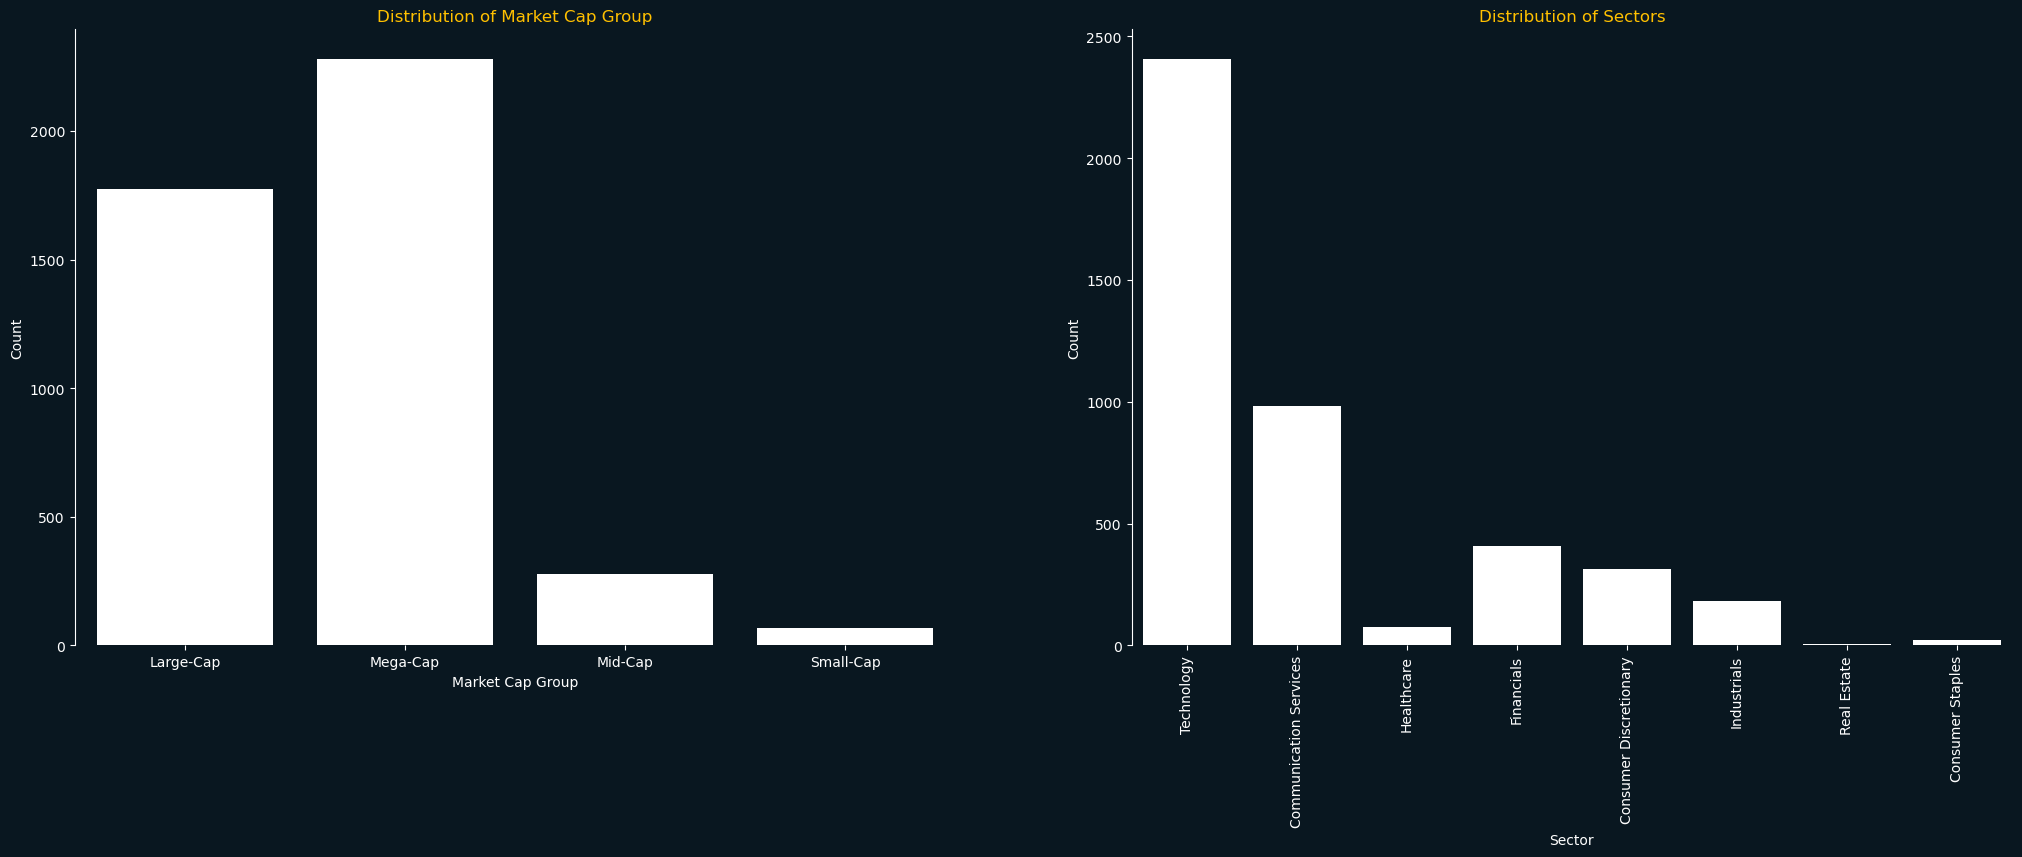

In [50]:
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')

sns.countplot(x='mc_group', data=public_companies, color='white', ax=ax[0])
ax[0].set_title('Distribution of Market Cap Group', color='#FFC000')
ax[0].set_ylabel('Count', color='white')
ax[0].set_xlabel('Market Cap Group', color='white')
ax[0].set_facecolor('#091720')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')


ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_color('white')
ax[0].set_xticklabels(ax[0].get_xticklabels())

sns.countplot(x='sector', data=public_companies, color='white', ax=ax[1])
ax[1].set_title('Distribution of Sectors', color='#FFC000')
ax[1].set_ylabel('Count', color='white')
ax[1].set_xlabel('Sector', color='white')
ax[1].set_facecolor('#091720')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')


ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_color('white')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)


plt.show()

## Reducing Skew

In [51]:
# removing real estate and consumer staples categories from dataset because of low representation
public_companies = public_companies[(public_companies['sector'] != 'Real Estate') & (public_companies['sector'] != 'Consumer Staples')]
public_companies.groupby('sector')['base_salary_std'].count()

sector
Communication Services     982
Consumer Discretionary     314
Financials                 407
Healthcare                  77
Industrials                182
Technology                2408
Name: base_salary_std, dtype: int64

In [52]:
#aggregating values with low representation in the sector category
sector = {"Healthcare": "other",
          "Consumer Discretionary": "other",
          "Financials": "other",
          "Industrials": "other"}

# Replace values
public_companies['sector'] = public_companies['sector'].replace(sector)

In [53]:
# aggregating values with low representation in the market cap group category
mc_group = {"Large-Cap": "large_cap_max",
        "Mid-Cap": "large_cap_max",
        "Small-Cap": "large_cap_max",}

# Replace values
public_companies['mc_group'] = public_companies['mc_group'].replace(mc_group)

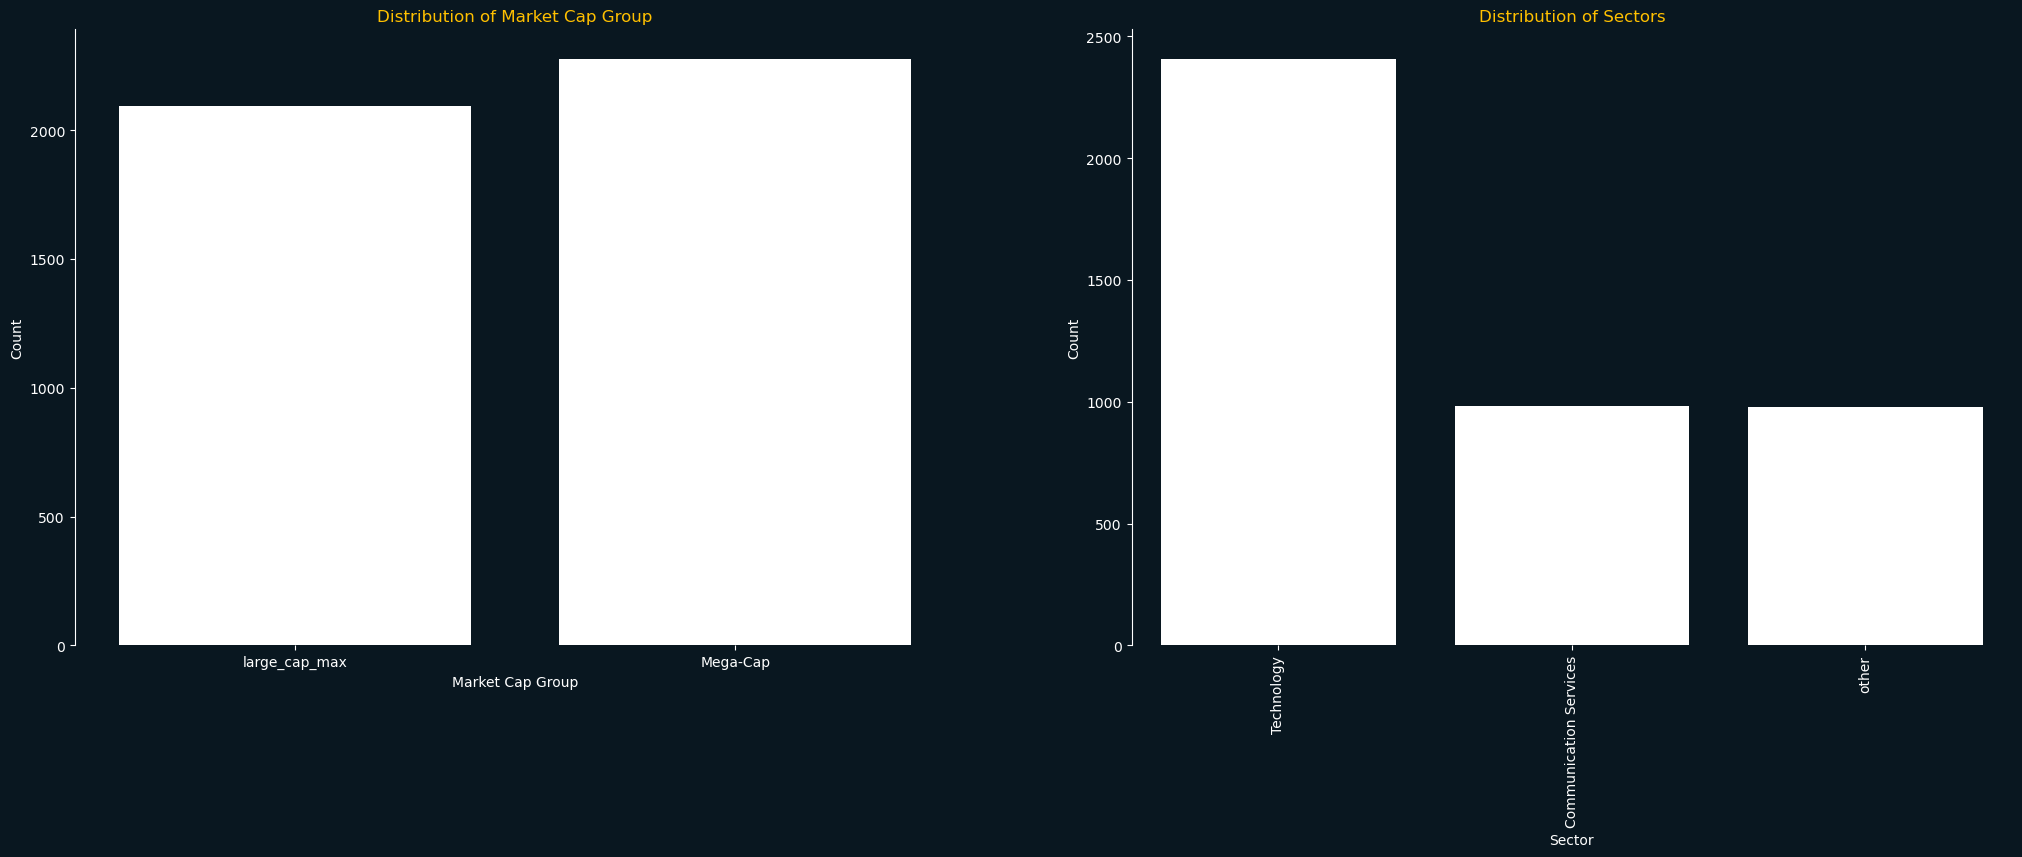

In [54]:
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')

sns.countplot(x='mc_group', data=public_companies, color='white', ax=ax[0])
ax[0].set_title('Distribution of Market Cap Group', color='#FFC000')
ax[0].set_ylabel('Count', color='white')
ax[0].set_xlabel('Market Cap Group', color='white')
ax[0].set_facecolor('#091720')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')


ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_color('white')
ax[0].set_xticklabels(ax[0].get_xticklabels())

sns.countplot(x='sector', data=public_companies, color='white', ax=ax[1])
ax[1].set_title('Distribution of Sectors', color='#FFC000')
ax[1].set_ylabel('Count', color='white')
ax[1].set_xlabel('Sector', color='white')
ax[1].set_facecolor('#091720')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')


ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_color('white')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)


plt.show()

In [55]:
# sampling overrepresented technology value in sector category
sector = public_companies[public_companies['sector'] == 'Technology']
sector = sector.sample(1000, random_state = 42)

# removing technology from sector category in dataset
public_companies = public_companies[public_companies['sector'] != 'Technology']

In [56]:
# adding sampled set of technology sectors to dataset
public_companies = pd.concat([public_companies, sector], ignore_index=True)

## Final Visualizations of Categorical Data

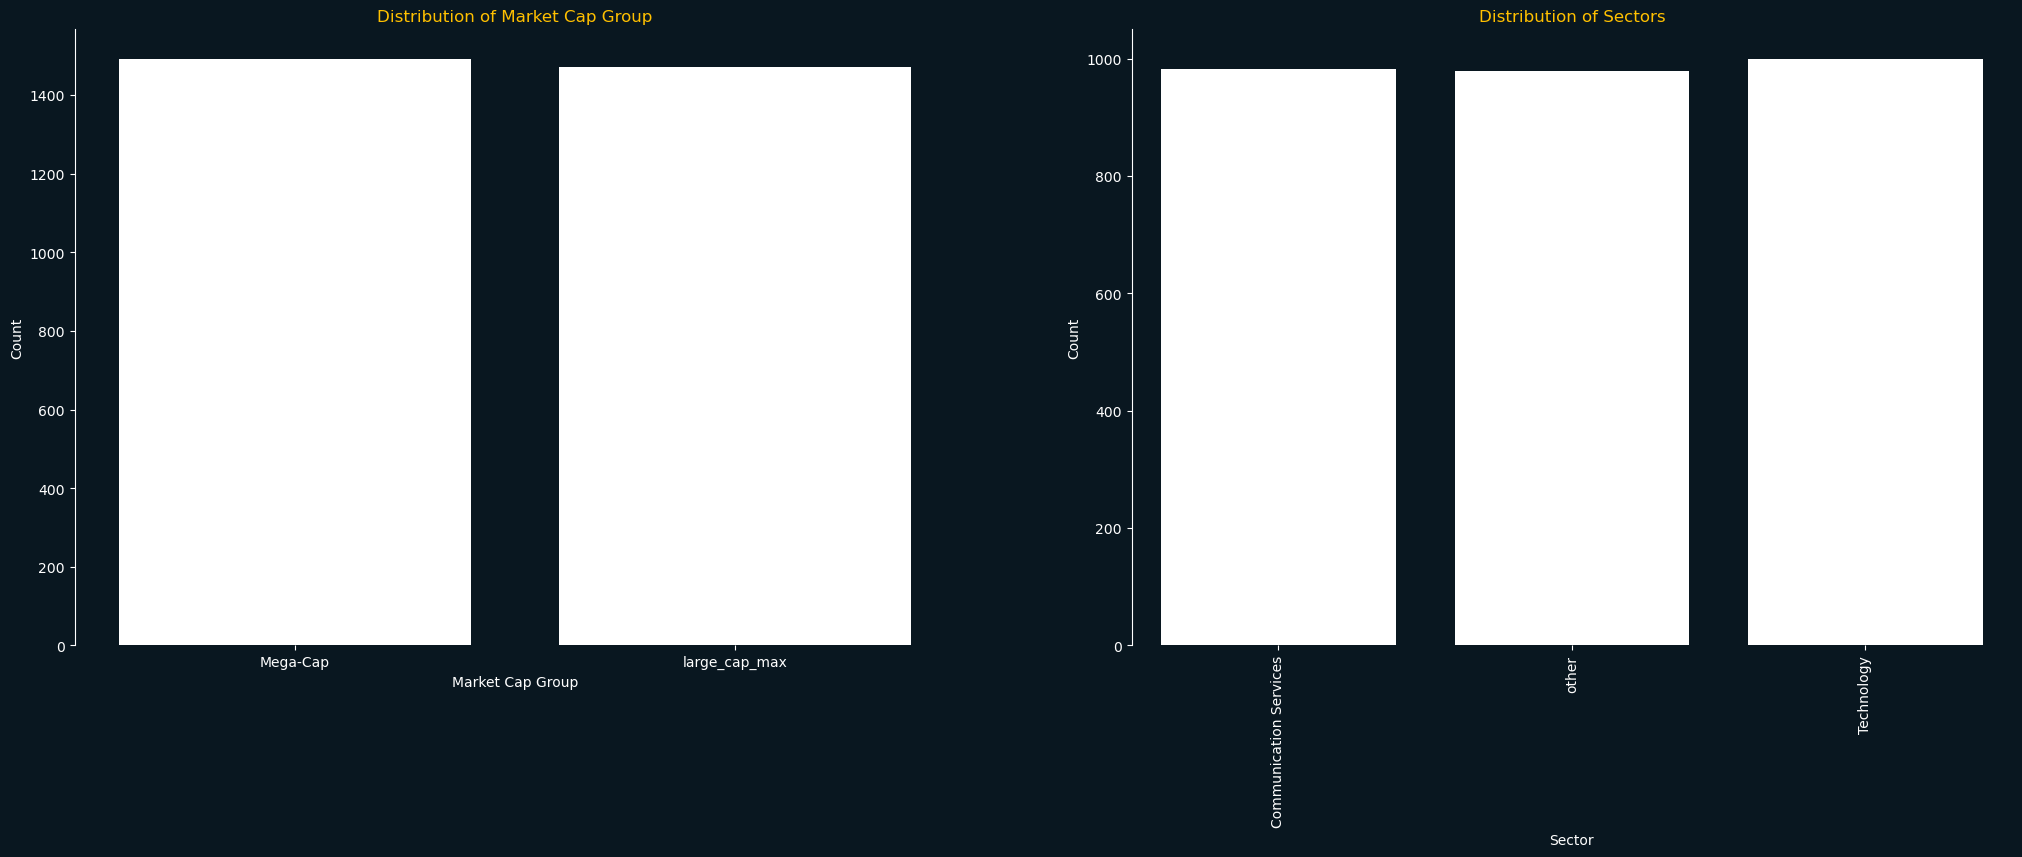

In [57]:
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')

sns.countplot(x='mc_group', data=public_companies, color='white', ax=ax[0])
ax[0].set_title('Distribution of Market Cap Group', color='#FFC000')
ax[0].set_ylabel('Count', color='white')
ax[0].set_xlabel('Market Cap Group', color='white')
ax[0].set_facecolor('#091720')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')


ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_color('white')
ax[0].set_xticklabels(ax[0].get_xticklabels())

sns.countplot(x='sector', data=public_companies, color='white', ax=ax[1])
ax[1].set_title('Distribution of Sectors', color='#FFC000')
ax[1].set_ylabel('Count', color='white')
ax[1].set_xlabel('Sector', color='white')
ax[1].set_facecolor('#091720')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')


ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_color('white')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=90)


plt.show()

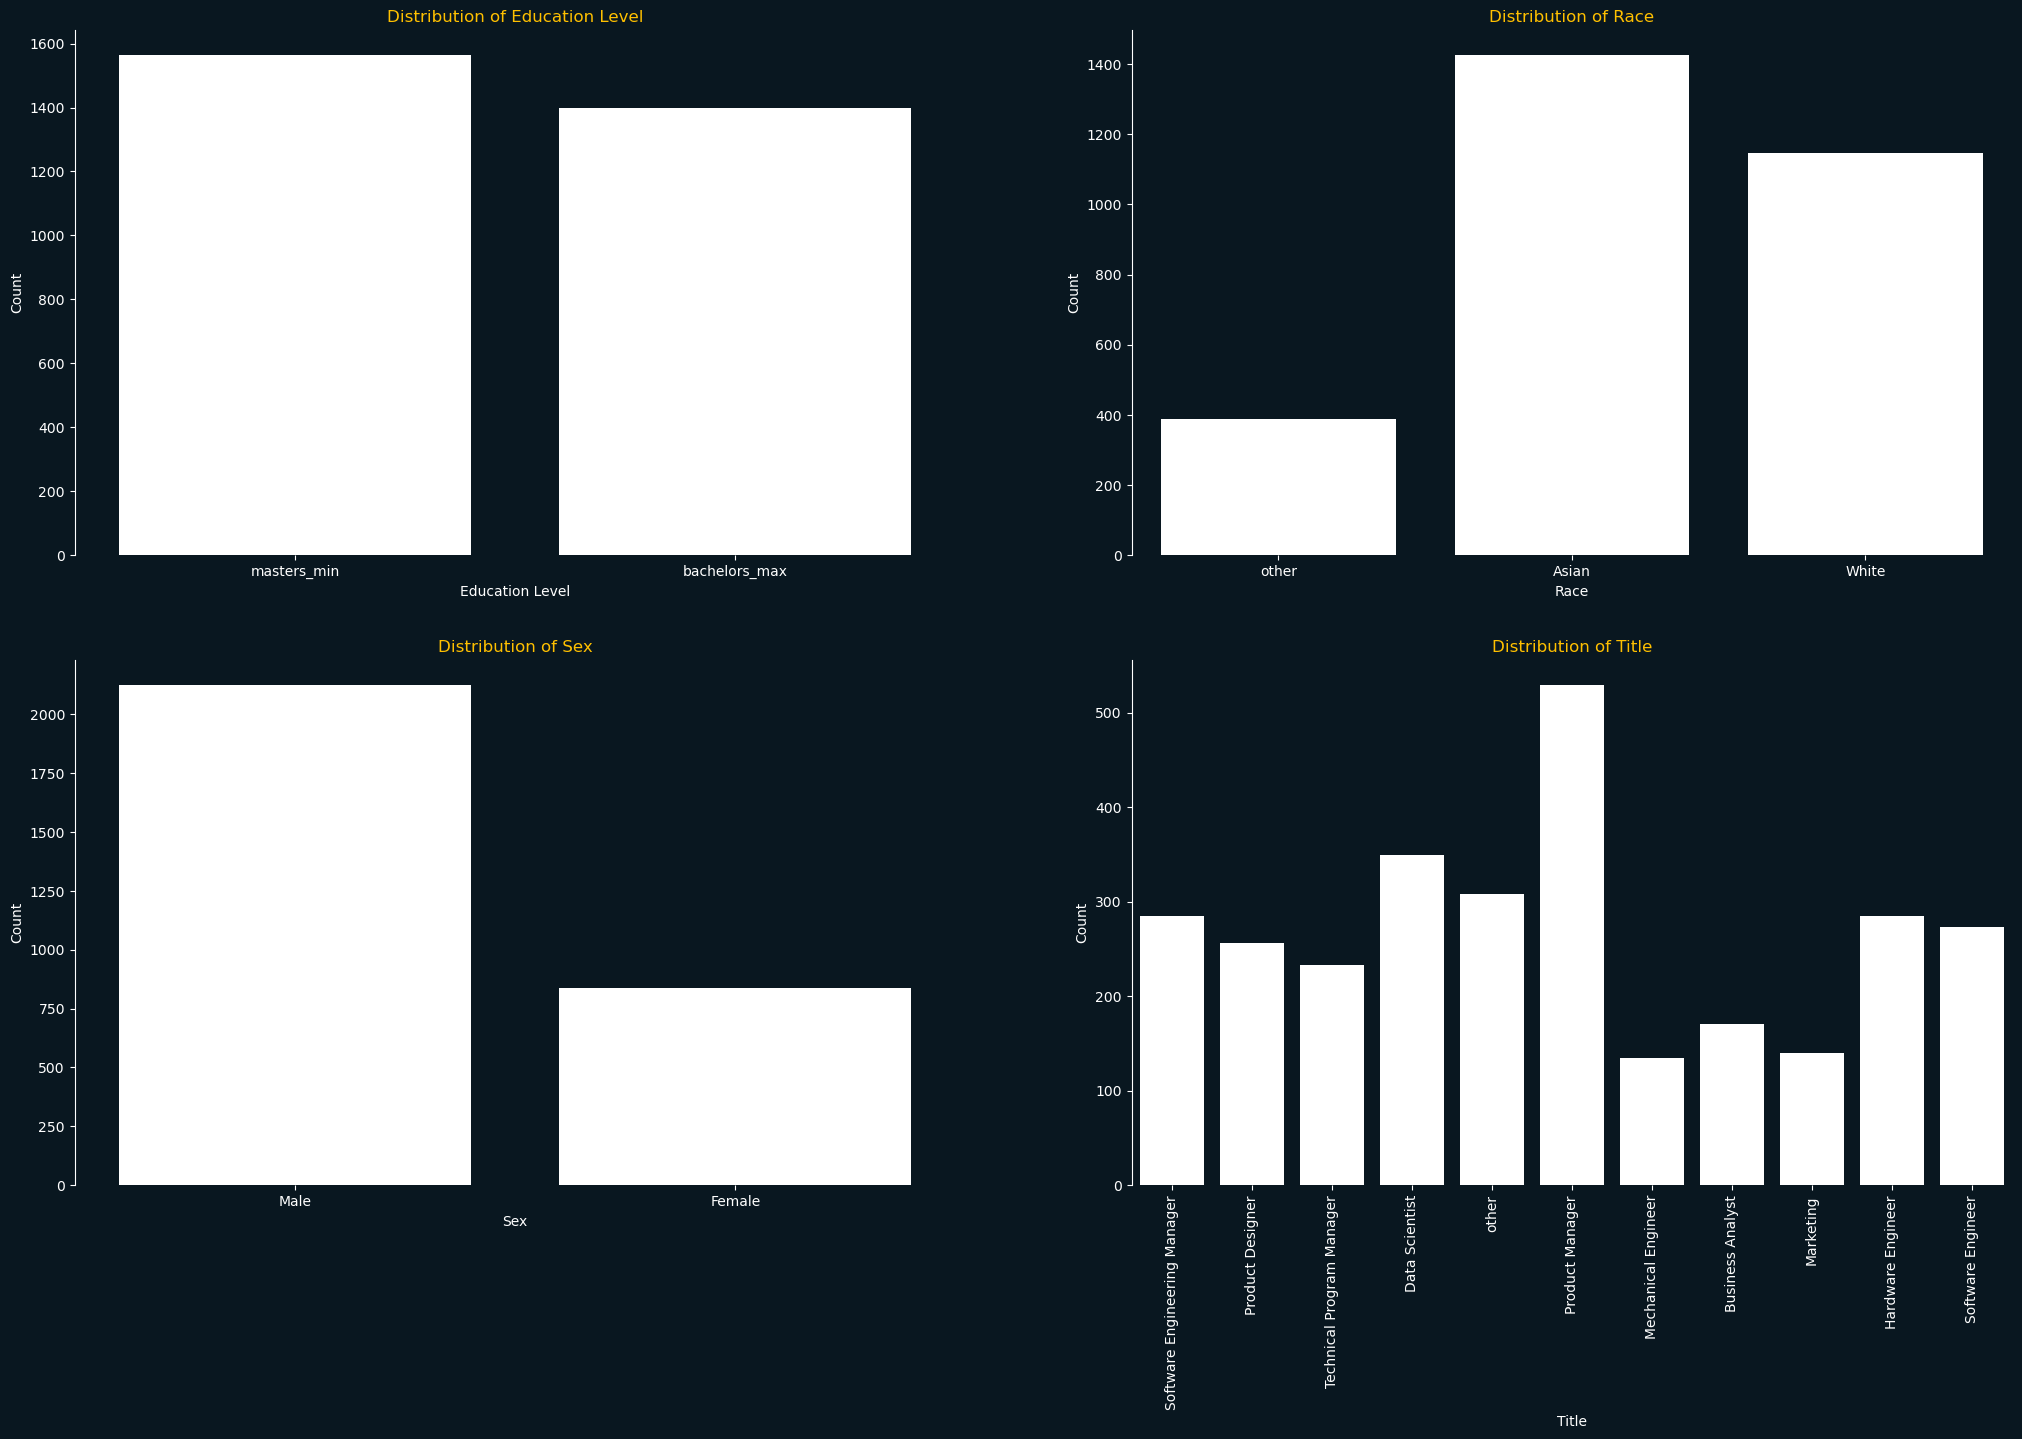

In [58]:
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')

sns.countplot(x='education', data=public_companies, color='white', ax=ax[0, 0])
ax[0, 0].set_title('Distribution of Education Level', color='#FFC000')
ax[0, 0].set_ylabel('Count', color='white')
ax[0, 0].set_xlabel('Education Level', color='white')
ax[0, 0].set_facecolor('#091720')
ax[0, 0].tick_params(axis='y', colors='white')
ax[0, 0].tick_params(axis='x', colors='white')


ax[0, 0].spines['top'].set_visible(False)
ax[0, 0].spines['bottom'].set_visible(False)
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['left'].set_color('white')

sns.countplot(x='race', data=public_companies, color='white', ax=ax[0, 1])
ax[0, 1].set_title('Distribution of Race', color='#FFC000')
ax[0, 1].set_ylabel('Count', color='white')
ax[0, 1].set_xlabel('Race', color='white')
ax[0, 1].set_facecolor('#091720')
ax[0, 1].tick_params(axis='y', colors='white')
ax[0, 1].tick_params(axis='x', colors='white')


ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['bottom'].set_visible(False)
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['left'].set_color('white')

sns.countplot(x='sex', data=public_companies, color='white', ax=ax[1, 0])
ax[1, 0].set_title('Distribution of Sex', color='#FFC000')
ax[1, 0].set_ylabel('Count', color='white')
ax[1, 0].set_xlabel('Sex', color='white')
ax[1, 0].set_facecolor('#091720')
ax[1, 0].tick_params(axis='y', colors='white')
ax[1, 0].tick_params(axis='x', colors='white')


ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].spines['bottom'].set_visible(False)
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['left'].set_color('white')

sns.countplot(x='title', data=public_companies, color='white', ax=ax[1, 1])
ax[1, 1].set_title('Distribution of Title', color='#FFC000')
ax[1, 1].set_ylabel('Count', color='white')
ax[1, 1].set_xlabel('Title', color='white')
ax[1, 1].set_facecolor('#091720')
ax[1, 1].tick_params(axis='y', colors='white')
ax[1, 1].tick_params(axis='x', colors='white')


ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines['bottom'].set_visible(False)
ax[1, 1].spines['right'].set_visible(False)
ax[1, 1].spines['left'].set_color('white')
ax[1, 1].set_xticklabels(ax[1, 1].get_xticklabels(), rotation=90)


plt.show()

# Categorical Data Encoding

In [59]:
# encoding nominal categories
public_companies_copy = public_companies
x=['title', 'race', 'sex', 'sector']
public_companies = pd.get_dummies(public_companies, columns=['title', 'race', 'sex', 'sector'], prefix=x, drop_first=True, dtype=int)

public_companies.loc[:, 'title_Data Scientist':'sector_Technology'].sample(3)

,title_Data Scientist,title_Hardware Engineer,title_Marketing,title_Mechanical Engineer,title_Product Designer,title_Product Manager,title_Software Engineer,title_Software Engineering Manager,title_Technical Program Manager,title_other,race_White,race_other,sex_Male,sector_Technology
317,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1385,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1838,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [60]:
# Encoding Ordinal categories
education_dict = {'masters_min': 0, 'bachelors_max': 1}
mc_group_dict = {'large_cap_max': 0, 'Mega-Cap': 1}

# Change values to correspond with dict values
public_companies['education_encoded'] = public_companies['education'].map(education_dict)
public_companies['mc_group_encoded'] = public_companies['mc_group'].map(mc_group_dict)

public_companies[['education', 'education_encoded', 'mc_group', 'mc_group_encoded']].sample(5)

,education,education_encoded,mc_group,mc_group_encoded
2039,masters_min,0,Mega-Cap,1
872,masters_min,0,Mega-Cap,1
1823,bachelors_max,1,large_cap_max,0
846,masters_min,0,large_cap_max,0
2635,bachelors_max,1,Mega-Cap,1


# Correlation Analysis

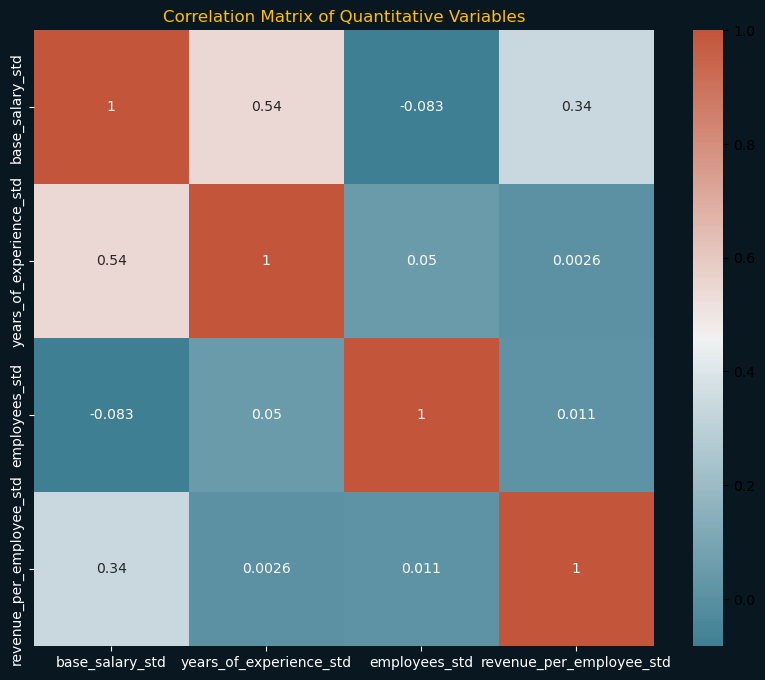

In [61]:
public_companies_cleaned = public_companies[['base_salary_std', 'years_of_experience_std',
                                             'employees_std', 'revenue_per_employee_std']]

corr_matrix = public_companies_cleaned.corr()

# Visualize correlation matrix)
plt.figure(figsize=(10, 8), facecolor='#091720')

sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

plt.tick_params(colors='white')
plt.title('Correlation Matrix of Quantitative Variables', color='#FFC000')
plt.show()

plt.show()

![multiple](multiple.png) 

# Split Dataset

In [62]:
# dropping dependent variable and nonstandardized variables
X = public_companies.drop(['base_salary_std', 'base_salary', 'years_of_experience', 'employees', 'revenue_per_employee', 'education', 'mc_group'], axis=1)
X.head(3)

,years_of_experience_std,employees_std,revenue_per_employee_std,title_Data Scientist,title_Hardware Engineer,title_Marketing,title_Mechanical Engineer,title_Product Designer,title_Product Manager,title_Software Engineer,title_Software Engineering Manager,title_Technical Program Manager,title_other,race_White,race_other,sex_Male,sector_Technology,sector_other,education_encoded,mc_group_encoded
0,1.081655,-0.517474,1.182587,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1
1,-0.057188,-0.399517,-0.320556,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1
2,-0.707955,-0.307317,0.830102,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,1


In [63]:
# dependent variable
y = public_companies['base_salary_std']
y.head(3)

0    1.022019
1   -0.498599
2   -0.012001
Name: base_salary_std, dtype: float64

In [65]:
import statsmodels.api as sm
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

#Add constant to independent variables
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Multivariate Linear Regression Modeling

## Analyze Removal of Quantitative Variables

Our goal is to evaluate quantitative variables based on p-value.  Those with a p-value over .05 will be eliminated from the model.  This will be done one by one with the maximum p-value being removed on each iteration.

In [66]:
lm1 = sm.OLS(y_train, X_train).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:        base_salary_std   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     137.3
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:27:42   Log-Likelihood:                -1616.8
No. Observations:                2073   AIC:                             3276.
Df Residuals:                    2052   BIC:                             3394.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
cons

In [67]:
y_pred = lm1.predict(X_test)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.33195128148317254
Linear Regression - MAE: 0.444886397870731


# Analyze Removal of Categorical Variables

Here we will be test building a model without each of the categorical variables with replacement.  We expect the overall fit of the model to decrease with each variable removed, however those with little impact on the overall fit will be removed from the variables of interest to maximize the effect of the most significant variables.

## Test Removing Education

In [68]:
X_train1 = X_train.drop(columns='education_encoded', inplace=False)
X_test1 = X_test.drop(columns='education_encoded', inplace=False)
lm = sm.OLS(y_train, X_train1)
lm = lm.fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        base_salary_std   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     138.7
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:27:43   Log-Likelihood:                -1641.5
No. Observations:                2073   AIC:                             3323.
Df Residuals:                    2053   BIC:                             3436.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.0268      0.080    -12.910      0.000      -1.183      -0.871
years_of_experience_std                0.4932      0.016     31.265      0.000       0.462       0.524
employees_std                         -0.7966      0.088     -9.083      0.000      -0.969      -0.625
revenue_per_employee_std               0.2331      0.024      9.754      0.000       0.186       0.280
title_Data Scientist                   0.7303      0.061     12.034      0.000       0.611       0.849
title_Hardware Engineer                0.3891      0.066      5.873      0.000       0.259       0.519
title_Marketing                        0.1956      0.075      2.621      0.009       0.049       0.342
title_Mechanical Engineer              0.2890      0.075      3.835      0.000       0.141       0.437
title_Product Designer                 0.5289      0.064      8.246      0.000       0.403       0.655
title_Product Manager                  0.6370      0.057     11.108      0.000       0.525       0.749
title_Software Engineer                0.5759      0.064      9.050      0.000       0.451       0.701
title_Software Engineering Manager     0.8387      0.065     12.909      0.000       0.711       0.966
title_Technical Program Manager        0.4170      0.067      6.220      0.000       0.286       0.548
title_other                            0.1027      0.063      1.624      0.105      -0.021       0.227
race_White                             0.0044      0.026      0.167      0.868      -0.047       0.056
race_other                            -0.0334      0.037     -0.905      0.366      -0.106       0.039
sex_Male                               0.1157      0.027      4.224      0.000       0.062       0.169
sector_Technology                     -0.0660      0.033     -1.972      0.049      -0.132      -0.000
sector_other                          -0.2815      0.037     -7.663      0.000      -0.354      -0.209
mc_group_encoded                       0.1826      0.037      4.969      0.000       0.111       0.255
==============================================================================
Omnibus:                       11.613   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.058
Skew:                           0.094   Prob(JB):                     0.000886
Kurtosis:                       3.357   Cond. No.                         23.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Result
>Removing education decreased r^2 and adjusted r^2 by .016.

In [69]:
y_pred = lm.predict(X_test1)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.3391749399474706
Linear Regression - MAE: 0.4501497879681051


# Test Removing Sex

In [70]:
X_train1 = X_train.drop(columns=['sex_Male'], inplace=False)
X_test1 = X_test.drop(columns=['sex_Male'], inplace=False)
lm = sm.OLS(y_train, X_train1)
lm = lm.fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        base_salary_std   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     142.5
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:27:43   Log-Likelihood:                -1625.7
No. Observations:                2073   AIC:                             3291.
Df Residuals:                    2053   BIC:                             3404.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.8654      0.077    -11.235      0.000      -1.016      -0.714
years_of_experience_std                0.4828      0.016     30.654      0.000       0.452       0.514
employees_std                         -0.7959      0.087     -9.146      0.000      -0.967      -0.625
revenue_per_employee_std               0.2270      0.024      9.572      0.000       0.180       0.274
title_Data Scientist                   0.6776      0.061     11.140      0.000       0.558       0.797
title_Hardware Engineer                0.3650      0.066      5.541      0.000       0.236       0.494
title_Marketing                        0.1864      0.074      2.521      0.012       0.041       0.331
title_Mechanical Engineer              0.2936      0.075      3.935      0.000       0.147       0.440
title_Product Designer                 0.5187      0.063      8.170      0.000       0.394       0.643
title_Product Manager                  0.6166      0.057     10.830      0.000       0.505       0.728
title_Software Engineer                0.5797      0.063      9.188      0.000       0.456       0.703
title_Software Engineering Manager     0.8686      0.064     13.468      0.000       0.742       0.995
title_Technical Program Manager        0.4057      0.067      6.101      0.000       0.275       0.536
title_other                            0.1107      0.063      1.765      0.078      -0.012       0.234
race_White                             0.0540      0.027      2.018      0.044       0.002       0.106
race_other                            -0.0082      0.037     -0.222      0.824      -0.080       0.064
sector_Technology                     -0.0818      0.033     -2.458      0.014      -0.147      -0.017
sector_other                          -0.2830      0.036     -7.764      0.000      -0.354      -0.212
education_encoded                     -0.1809      0.026     -7.049      0.000      -0.231      -0.131
mc_group_encoded                       0.1872      0.036      5.135      0.000       0.116       0.259
==============================================================================
Omnibus:                       15.339   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               19.485
Skew:                           0.107   Prob(JB):                     5.87e-05
Kurtosis:                       3.424   Cond. No.                         22.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Result
>Removing sex decreased r^2 and adjusted r^2 by .001.  We can conlude based on this that sex is not a significant variable to the model.

In [71]:
y_pred = lm.predict(X_test1)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.3302303171165089
Linear Regression - MAE: 0.4441622998915389


# Test Removing Race

In [72]:
X_train1 = X_train.drop(columns=['race_White', 'race_other'], inplace=False)
X_test1 = X_test.drop(columns=['race_White', 'race_other'], inplace=False)
lm = sm.OLS(y_train, X_train1)
lm = lm.fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        base_salary_std   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     152.2
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:27:43   Log-Likelihood:                -1618.8
No. Observations:                2073   AIC:                             3276.
Df Residuals:                    2054   BIC:                             3383.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.9403      0.079    -11.955      0.000      -1.095      -0.786
years_of_experience_std                0.4762      0.016     30.150      0.000       0.445       0.507
employees_std                         -0.8037      0.087     -9.273      0.000      -0.974      -0.634
revenue_per_employee_std               0.2285      0.024      9.672      0.000       0.182       0.275
title_Data Scientist                   0.6757      0.061     11.161      0.000       0.557       0.794
title_Hardware Engineer                0.3450      0.066      5.243      0.000       0.216       0.474
title_Marketing                        0.2133      0.074      2.900      0.004       0.069       0.358
title_Mechanical Engineer              0.2751      0.074      3.693      0.000       0.129       0.421
title_Product Designer                 0.5441      0.063      8.583      0.000       0.420       0.668
title_Product Manager                  0.6291      0.057     11.105      0.000       0.518       0.740
title_Software Engineer                0.5679      0.063      9.023      0.000       0.444       0.691
title_Software Engineering Manager     0.8629      0.064     13.439      0.000       0.737       0.989
title_Technical Program Manager        0.4133      0.066      6.235      0.000       0.283       0.543
title_other                            0.1345      0.062      2.155      0.031       0.012       0.257
sex_Male                               0.1168      0.027      4.321      0.000       0.064       0.170
sector_Technology                     -0.0814      0.033     -2.463      0.014      -0.146      -0.017
sector_other                          -0.2831      0.036     -7.802      0.000      -0.354      -0.212
education_encoded                     -0.1694      0.025     -6.816      0.000      -0.218      -0.121
mc_group_encoded                       0.1831      0.036      5.044      0.000       0.112       0.254
==============================================================================
Omnibus:                       13.979   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.142
Skew:                           0.110   Prob(JB):                     0.000189
Kurtosis:                       3.388   Cond. No.                         23.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Result
>Removing race decreased r^2 and adjusted r^2 by .003 indicating race is not a significant variable to the model.

In [73]:
y_pred = lm.predict(X_test1)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.3327151221233799
Linear Regression - MAE: 0.44534509839679476


# Test Removing Sector

In [74]:
X_train1 = X_train.drop(columns=['sector_Technology', 'sector_other'], inplace=False)
X_test1 = X_test.drop(columns=['sector_Technology', 'sector_other'], inplace=False)
lm = sm.OLS(y_train, X_train1)
lm = lm.fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        base_salary_std   R-squared:                       0.559
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     144.4
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:27:43   Log-Likelihood:                -1649.9
No. Observations:                2073   AIC:                             3338.
Df Residuals:                    2054   BIC:                             3445.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -1.1760      0.074    -15.814      0.000      -1.322      -1.030
years_of_experience_std                0.4728      0.016     29.433      0.000       0.441       0.504
employees_std                         -0.8478      0.088     -9.646      0.000      -1.020      -0.675
revenue_per_employee_std               0.2797      0.022     12.760      0.000       0.237       0.323
title_Data Scientist                   0.7002      0.061     11.398      0.000       0.580       0.821
title_Hardware Engineer                0.4061      0.065      6.286      0.000       0.279       0.533
title_Marketing                        0.2888      0.074      3.896      0.000       0.143       0.434
title_Mechanical Engineer              0.2500      0.076      3.306      0.001       0.102       0.398
title_Product Designer                 0.5979      0.064      9.344      0.000       0.472       0.723
title_Product Manager                  0.6670      0.057     11.653      0.000       0.555       0.779
title_Software Engineer                0.6201      0.064      9.763      0.000       0.496       0.745
title_Software Engineering Manager     0.8920      0.065     13.706      0.000       0.764       1.020
title_Technical Program Manager        0.4726      0.067      7.077      0.000       0.342       0.604
title_other                            0.1830      0.063      2.898      0.004       0.059       0.307
race_White                             0.0503      0.027      1.860      0.063      -0.003       0.103
race_other                            -0.0180      0.037     -0.486      0.627      -0.091       0.055
sex_Male                               0.1160      0.027      4.222      0.000       0.062       0.170
education_encoded                     -0.1854      0.026     -7.153      0.000      -0.236      -0.135
mc_group_encoded                       0.2577      0.036      7.239      0.000       0.188       0.328
==============================================================================
Omnibus:                        9.387   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.009   Jarque-Bera (JB):               10.718
Skew:                           0.095   Prob(JB):                      0.00471
Kurtosis:                       3.297   Cond. No.                         23.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Result
>Removing sector decreased r^2 and adjusted r^2 by .021.

In [75]:
y_pred = lm.predict(X_test1)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.3467187191582684
Linear Regression - MAE: 0.45947059103144144


# Test Removing Market Cap Group

In [76]:
X_train1 = X_train.drop(columns=['mc_group_encoded'], inplace=False)
X_test1 = X_test.drop(columns=['mc_group_encoded'], inplace=False)
lm = sm.OLS(y_train, X_train1)
lm = lm.fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        base_salary_std   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     141.5
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:27:43   Log-Likelihood:                -1629.9
No. Observations:                2073   AIC:                             3300.
Df Residuals:                    2053   BIC:                             3413.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.7429      0.069    -10.835      0.000      -0.877      -0.608
years_of_experience_std                0.4733      0.016     29.707      0.000       0.442       0.505
employees_std                         -0.5621      0.073     -7.705      0.000      -0.705      -0.419
revenue_per_employee_std               0.2948      0.020     14.733      0.000       0.256       0.334
title_Data Scientist                   0.6656      0.061     10.914      0.000       0.546       0.785
title_Hardware Engineer                0.3223      0.066      4.880      0.000       0.193       0.452
title_Marketing                        0.1869      0.074      2.520      0.012       0.041       0.332
title_Mechanical Engineer              0.2579      0.075      3.440      0.001       0.111       0.405
title_Product Designer                 0.5361      0.064      8.403      0.000       0.411       0.661
title_Product Manager                  0.6145      0.057     10.772      0.000       0.503       0.726
title_Software Engineer                0.5538      0.063      8.755      0.000       0.430       0.678
title_Software Engineering Manager     0.8536      0.065     13.200      0.000       0.727       0.980
title_Technical Program Manager        0.4173      0.067      6.260      0.000       0.287       0.548
title_other                            0.1248      0.063      1.982      0.048       0.001       0.248
race_White                             0.0460      0.027      1.713      0.087      -0.007       0.099
race_other                            -0.0003      0.037     -0.008      0.994      -0.073       0.072
sex_Male                               0.1152      0.027      4.228      0.000       0.062       0.169
sector_Technology                     -0.0742      0.033     -2.225      0.026      -0.140      -0.009
sector_other                          -0.3171      0.036     -8.859      0.000      -0.387      -0.247
education_encoded                     -0.1783      0.026     -6.930      0.000      -0.229      -0.128
==============================================================================
Omnibus:                       11.618   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               15.085
Skew:                           0.061   Prob(JB):                     0.000530
Kurtosis:                       3.399   Cond. No.                         23.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Result
>Removing market cap group decreased r^2 by .002 and adjusted r^2 by .001 indicating market cap group is not significant to the model.

In [77]:
y_pred = lm.predict(X_test1)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.33260612968755343
Linear Regression - MAE: 0.4472174567425453


# Test Removing Title

In [78]:
X_train1 = X_train.drop(columns=['title_Data Scientist',
                                 'title_Hardware Engineer',
                                 'title_Marketing',
                                 'title_Mechanical Engineer',	
                                 'title_Product Designer',	
                                 'title_Product Manager',	
                                 'title_Software Engineer',	
                                 'title_Software Engineering Manager',	
                                 'title_Technical Program Manager',
                                 'title_other'], inplace=False)
X_test1 = X_test.drop(columns=[  'title_Data Scientist',
                                 'title_Hardware Engineer',
                                 'title_Marketing',
                                 'title_Mechanical Engineer',	
                                 'title_Product Designer',	
                                 'title_Product Manager',	
                                 'title_Software Engineer',	
                                 'title_Software Engineering Manager',	
                                 'title_Technical Program Manager',
                                 'title_other'], inplace=False)
lm = sm.OLS(y_train, X_train1)
lm = lm.fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        base_salary_std   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     197.2
Date:                Mon, 15 Apr 2024   Prob (F-statistic):          9.68e-292
Time:                        19:27:43   Log-Likelihood:                -1801.9
No. Observations:                2073   AIC:                             3626.
Df Residuals:                    2062   BIC:                             3688.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.4963      0.068     -7.283      0.000      -0.630      -0.363
years_of_experience_std      0.4959      0.015     32.921      0.000       0.466       0.525
employees_std               -0.8925      0.094     -9.486      0.000      -1.077      -0.708
revenue_per_employee_std     0.2143      0.025      8.426      0.000       0.164       0.264
race_White                   0.0379      0.029      1.317      0.188      -0.019       0.094
race_other                  -0.0781      0.040     -1.974      0.048      -0.156      -0.001
sex_Male                     0.1490      0.029      5.227      0.000       0.093       0.205
sector_Technology           -0.1048      0.035     -3.020      0.003      -0.173      -0.037
sector_other                -0.2926      0.039     -7.540      0.000      -0.369      -0.217
education_encoded           -0.2138      0.027     -7.999      0.000      -0.266      -0.161
mc_group_encoded             0.1893      0.039      4.810      0.000       0.112       0.267
==============================================================================
Omnibus:                        4.950   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                5.244
Skew:                           0.070   Prob(JB):                       0.0727
Kurtosis:                       3.203   Cond. No.                         14.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Result
>Removing title decreased r^2 by .042 and adjusted r^2 by .041.

In [79]:
y_pred = lm.predict(X_test1)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.38688766134312186
Linear Regression - MAE: 0.4928550813220387


# Test Removing Combinations of Categorical Variables

In [80]:
X_train_final = X_train.drop(columns=['sex_Male', 
                                      'mc_group_encoded',
                                      'race_White',
                                      'race_other'], inplace=False)
X_test_final = X_test.drop(columns=[  'sex_Male', 
                                      'mc_group_encoded',
                                      'race_White',
                                      'race_other'], inplace=False)
X_final = X.drop(columns=[            'sex_Male', 
                                      'mc_group_encoded',
                                      'race_White',
                                      'race_other'], inplace=False)

lm = sm.OLS(y_train, X_train_final)
lm = lm.fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        base_salary_std   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.559
Method:                 Least Squares   F-statistic:                     165.1
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        19:27:43   Log-Likelihood:                -1641.0
No. Observations:                2073   AIC:                             3316.
Df Residuals:                    2056   BIC:                             3412.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.6433      0.065     -9.963      0.000      -0.770      -0.517
years_of_experience_std                0.4853      0.016     30.729      0.000       0.454       0.516
employees_std                         -0.5521      0.073     -7.554      0.000      -0.695      -0.409
revenue_per_employee_std               0.2906      0.020     14.480      0.000       0.251       0.330
title_Data Scientist                   0.6820      0.061     11.159      0.000       0.562       0.802
title_Hardware Engineer                0.3444      0.066      5.206      0.000       0.215       0.474
title_Marketing                        0.1780      0.074      2.402      0.016       0.033       0.323
title_Mechanical Engineer              0.2904      0.075      3.874      0.000       0.143       0.437
title_Product Designer                 0.5202      0.064      8.146      0.000       0.395       0.645
title_Product Manager                  0.6153      0.057     10.759      0.000       0.503       0.728
title_Software Engineer                0.5692      0.063      8.972      0.000       0.445       0.694
title_Software Engineering Manager     0.8693      0.065     13.414      0.000       0.742       0.996
title_Technical Program Manager        0.4107      0.067      6.135      0.000       0.279       0.542
title_other                            0.1152      0.063      1.829      0.067      -0.008       0.239
sector_Technology                     -0.0828      0.033     -2.479      0.013      -0.148      -0.017
sector_other                          -0.3232      0.036     -8.998      0.000      -0.394      -0.253
education_encoded                     -0.1684      0.025     -6.707      0.000      -0.218      -0.119
==============================================================================
Omnibus:                       16.055   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               22.310
Skew:                           0.073   Prob(JB):                     1.43e-05
Kurtosis:                       3.487   Cond. No.                         19.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Result
>Removing sex, market cap group, and race decreased r^2 and adjusted r^2 by .006 indicating these variables are not significant to the model.

In [81]:
y_pred = lm.predict(X_test_final)
lr_mse = mean_squared_error(y_test, y_pred)
lr_mae = mean_absolute_error(y_test, y_pred)
lr_r2 = lm.rsquared
lr_ar2 = lm.rsquared_adj



print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Linear Regression - MSE: 0.3313067784897206
Linear Regression - MAE: 0.4467626550763116


# Model with Original Dataset Variables Exclusively

> Here we want to analyze the difference between models calculated with the stock dataset and without to compare overall fit.

In [82]:
X_train2 = X_train.drop(columns=['employees_std',
                                 'revenue_per_employee_std', 
                                 'mc_group_encoded',
                                 'sector_other',
                                 'sector_Technology'], inplace=False)
                                 
       
X_test2 = X_test.drop(columns=[  'employees_std',
                                 'revenue_per_employee_std', 
                                 'mc_group_encoded',
                                 'sector_other',
                                 'sector_Technology'], inplace=False)
                               
lm1 = sm.OLS(y_train, X_train2)
lm1 = lm1.fit()
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        base_salary_std   R-squared:                       0.424
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     101.1
Date:                Mon, 15 Apr 2024   Prob (F-statistic):          1.83e-233
Time:                        19:27:43   Log-Likelihood:                -1925.0
No. Observations:                2073   AIC:                             3882.
Df Residuals:                    2057   BIC:                             3972.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -0.6935      0.064    -10.883      0.000      -0.818      -0.569
years_of_experience_std                0.4705      0.018     25.679      0.000       0.435       0.506
title_Data Scientist                   0.7849      0.070     11.219      0.000       0.648       0.922
title_Hardware Engineer                0.5547      0.073      7.565      0.000       0.411       0.699
title_Marketing                        0.4072      0.084      4.825      0.000       0.242       0.573
title_Mechanical Engineer              0.2285      0.086      2.650      0.008       0.059       0.398
title_Product Designer                 0.7740      0.073     10.666      0.000       0.632       0.916
title_Product Manager                  0.7143      0.065     10.946      0.000       0.586       0.842
title_Software Engineer                0.7122      0.072      9.847      0.000       0.570       0.854
title_Software Engineering Manager     0.9430      0.074     12.705      0.000       0.797       1.089
title_Technical Program Manager        0.6284      0.076      8.302      0.000       0.480       0.777
title_other                            0.2833      0.072      3.940      0.000       0.142       0.424
race_White                             0.0245      0.031      0.796      0.426      -0.036       0.085
race_other                            -0.0368      0.042     -0.871      0.384      -0.120       0.046
sex_Male                               0.1045      0.031      3.334      0.001       0.043       0.166
education_encoded                     -0.1912      0.030     -6.468      0.000      -0.249      -0.133
==============================================================================
Omnibus:                        0.195   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.907   Jarque-Bera (JB):                0.154
Skew:                           0.018   Prob(JB):                        0.926
Kurtosis:                       3.023   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [107]:
y_pred2 = lm1.predict(X_test2)
print("Linear Regression - MSE:",  mean_squared_error(y_test, y_pred2))
print("Linear Regression - MAE:", mean_absolute_error(y_test, y_pred2))

Linear Regression - MSE: 0.42933103244451315
Linear Regression - MAE: 0.5208605733404055


# Testing Assumptions

In [84]:
# dropping columns still in X that were dropped for the final linear regression model
X = X.drop(columns=[ 'sex_Male', 
                     'mc_group_encoded',
                     'race_White',
                     'race_other'], axis=1)
X.sample(3)

,years_of_experience_std,employees_std,revenue_per_employee_std,title_Data Scientist,title_Hardware Engineer,title_Marketing,title_Mechanical Engineer,title_Product Designer,title_Product Manager,title_Software Engineer,title_Software Engineering Manager,title_Technical Program Manager,title_other,sector_Technology,sector_other,education_encoded
52,0.756272,-0.590745,0.176183,0,0,0,0,0,1,0,0,0,0,0,1,0
1690,-1.033339,-0.615402,-0.165001,0,0,0,0,0,1,0,0,0,0,0,1,1
2578,-0.707955,-0.236781,0.104547,1,0,0,0,0,0,0,0,0,0,1,0,1


# Linearity

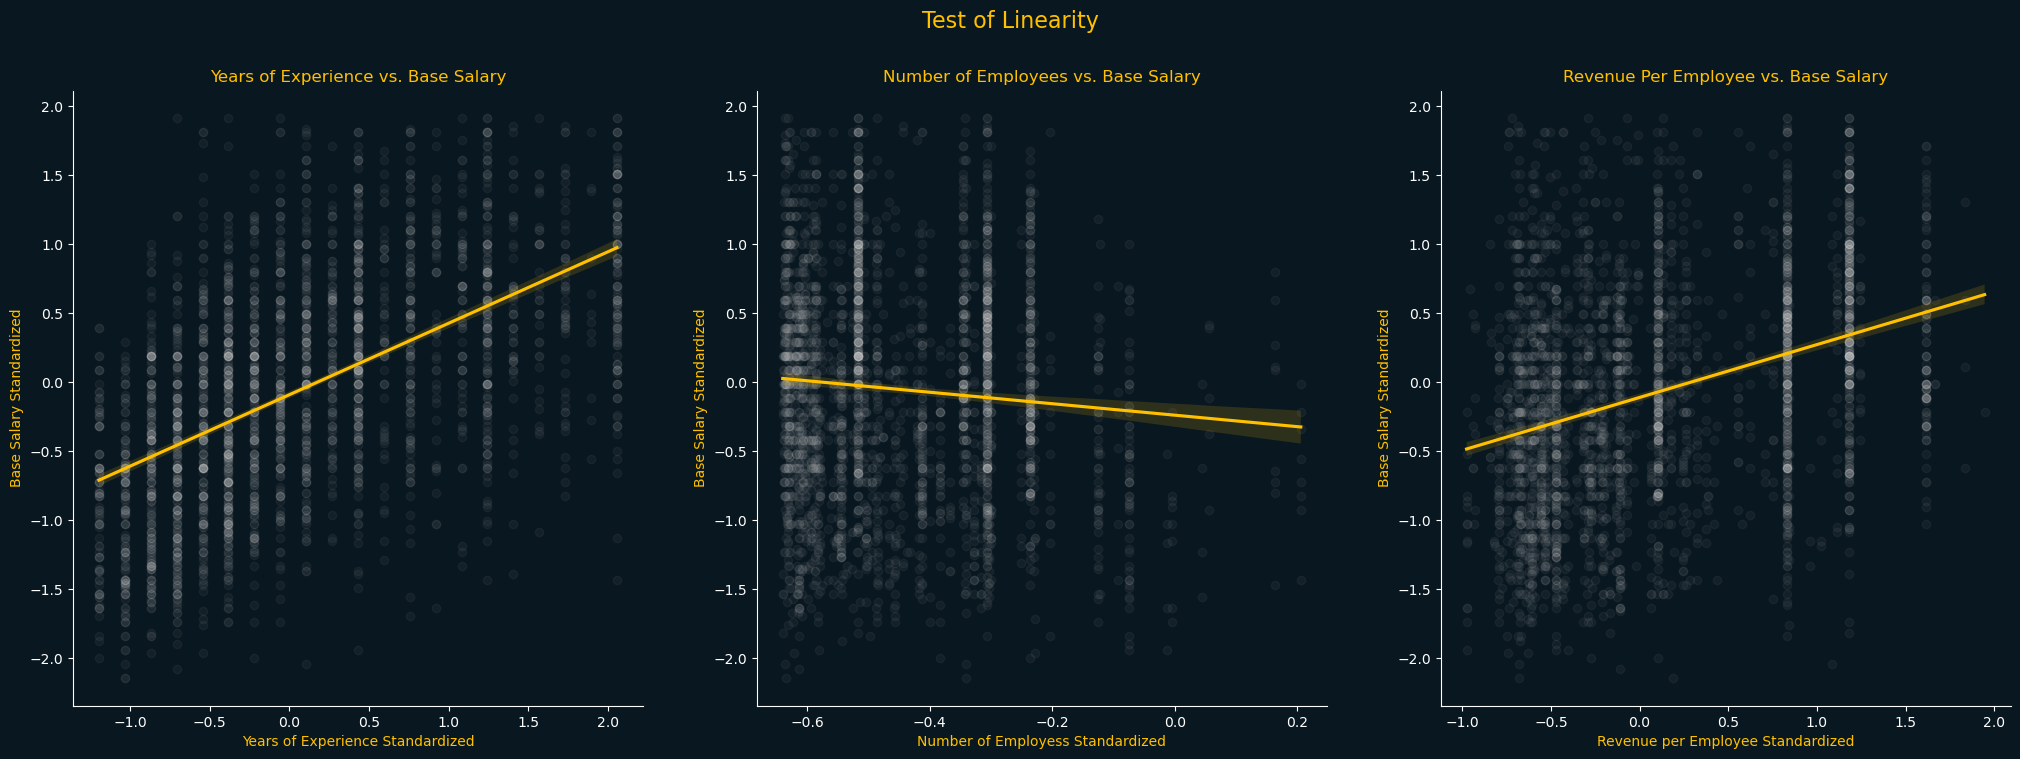

In [85]:
fig, ax = plt.subplots(ncols=3)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Test of Linearity', color='#FFC000', fontsize=16)

# Years of Experience
sns.regplot(x=X['years_of_experience_std'], y=y, line_kws={'color': '#FFC000'}, scatter_kws={'color': 'lightgrey', 'alpha': 0.05}, ax=ax[0])
ax[0].set_title('Years of Experience vs. Base Salary', color='#FFC000')
ax[0].set_xlabel('Years of Experience Standardized', color='#FFC000')
ax[0].set_ylabel('Base Salary Standardized', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')

ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

# Number of Employees
sns.regplot(x=X['employees_std'], y=y, line_kws={'color': '#FFC000'}, scatter_kws={'color': 'lightgrey', 'alpha': 0.05}, ax=ax[1])
ax[1].set_title('Number of Employees vs. Base Salary', color='#FFC000')
ax[1].set_xlabel('Number of Employess Standardized', color='#FFC000')
ax[1].set_ylabel('Base Salary Standardized', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

# Revenue per Employee
sns.regplot(x=X['revenue_per_employee_std'], y=y, line_kws={'color': '#FFC000'}, scatter_kws={'color': 'lightgrey', 'alpha': 0.05}, ax=ax[2])
ax[2].set_title('Revenue Per Employee vs. Base Salary', color='#FFC000')
ax[2].set_xlabel('Revenue per Employee Standardized', color='#FFC000')
ax[2].set_ylabel('Base Salary Standardized', color='#FFC000')
ax[2].tick_params(axis='y', colors='white')
ax[2].tick_params(axis='x', colors='white')

ax[2].spines['bottom'].set_color('white')
ax[2].spines['top'].set_color('#091720') 
ax[2].spines['right'].set_color('#091720')
ax[2].spines['left'].set_color('white')
ax[2].set_facecolor('#091720')
plt.show()


# Collinearity

In [86]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF scores for all the predictors
VIFs = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
for i, vif in enumerate(VIFs):
    print(f"VIF for {X.columns[i]}: {vif}")

VIF for years_of_experience_std: 1.29840044847395
VIF for employees_std: 6.736588283094189
VIF for revenue_per_employee_std: 1.5600864036487871
VIF for title_Data Scientist: 1.852844494580376
VIF for title_Hardware Engineer: 1.9759989004278007
VIF for title_Marketing: 1.3768494247688081
VIF for title_Mechanical Engineer: 1.3253527606548106
VIF for title_Product Designer: 1.6657330024819281
VIF for title_Product Manager: 2.370298031511926
VIF for title_Software Engineer: 1.6720828383678916
VIF for title_Software Engineering Manager: 1.9328233075516656
VIF for title_Technical Program Manager: 1.568236055996755
VIF for title_other: 1.8146107050999423
VIF for sector_Technology: 2.4980845049555307
VIF for sector_other: 2.7540121923774343
VIF for education_encoded: 2.0108527907814073


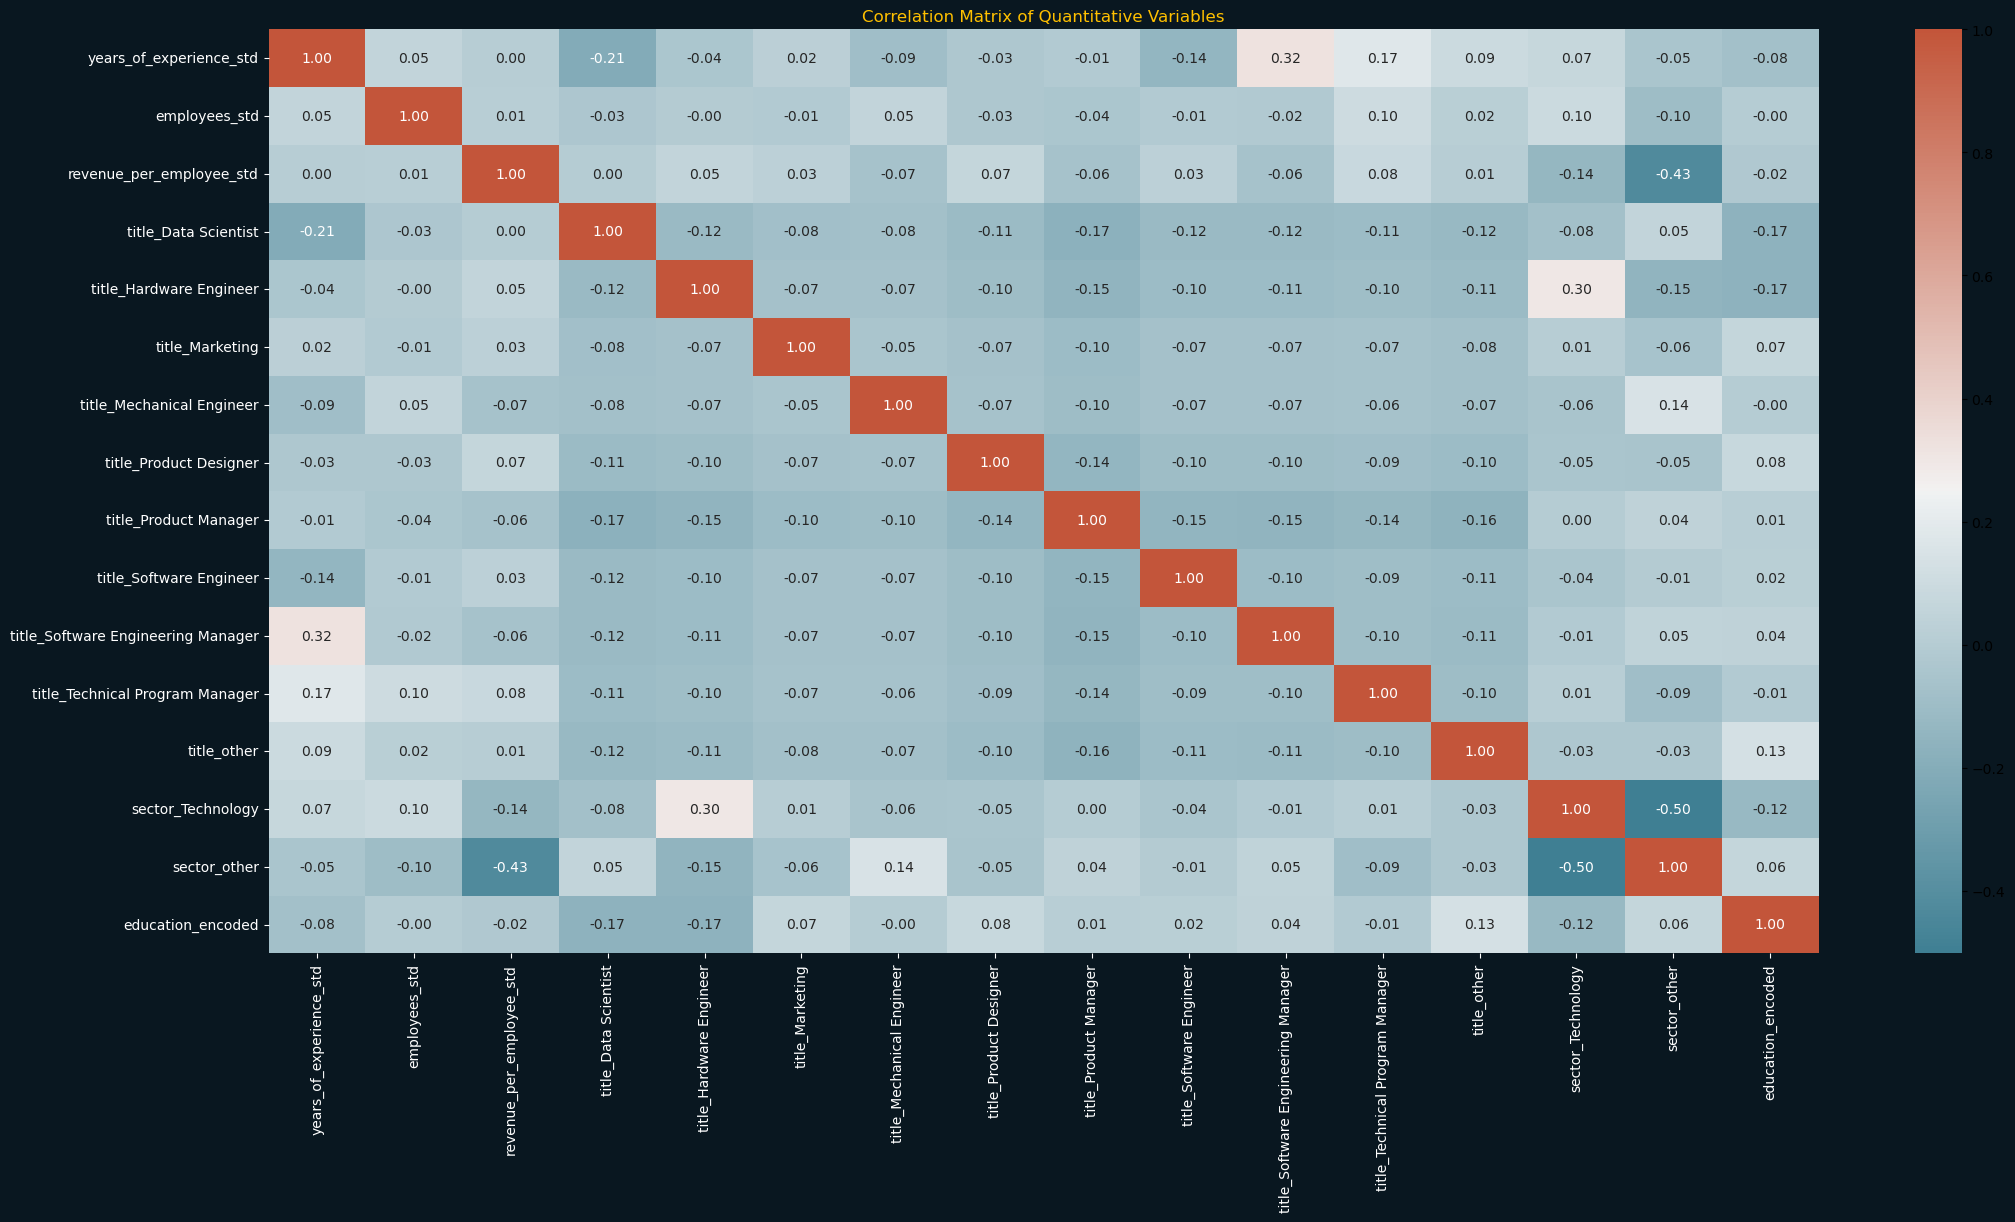

In [87]:
# Compute the correlation matrix
corr_matrix = X.corr()

# Visualize correlation matrix)
plt.figure(figsize=(25, 12), facecolor='#091720')

sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_matrix, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True), fmt=".2f")

plt.tick_params(colors='white')
plt.title('Correlation Matrix of Quantitative Variables', color='#FFC000')
plt.show()

plt.show()

# Normality of Residuals

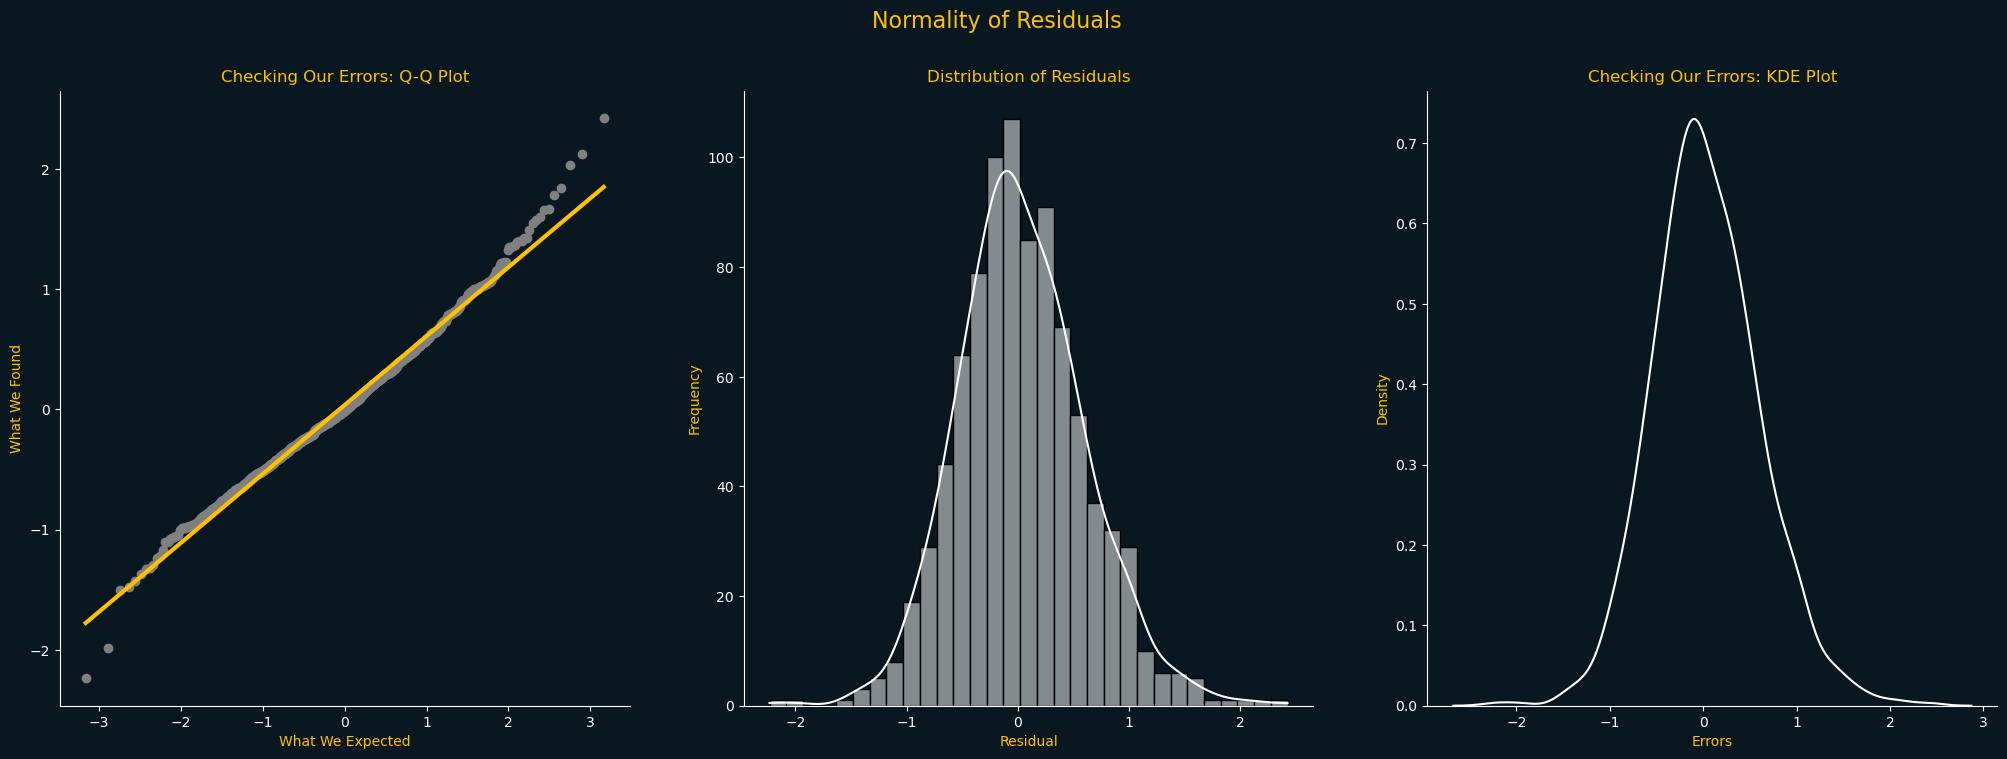

In [88]:
import scipy.stats as stats

residuals = y_test - y_pred

fig, ax = plt.subplots(ncols=3)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Normality of Residuals', color='#FFC000', fontsize=16)

#Q-Q Plot
stats.probplot(residuals, dist="norm", plot=ax[0])
ax[0].set_title('Checking Our Errors: Q-Q Plot', color='#FFC000')
ax[0].set_xlabel('What We Expected', color='#FFC000')
ax[0].set_ylabel('What We Found', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')

ax[0].get_lines()[0].set_color('grey')
ax[0].get_lines()[1].set_color('#FFC000')
ax[0].get_lines()[1].set_linewidth(3)

ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

# distribution of residuals
sns.histplot(residuals, kde=True, ax=ax[1], color='white')
ax[1].set_title('Distribution of Residuals', color='#FFC000')
ax[1].set_xlabel('Residual', color='#FFC000')
ax[1].set_ylabel('Frequency', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

# KDE Plot
sns.kdeplot(residuals, ax=ax[2], color='white')
ax[2].set_title('Checking Our Errors: KDE Plot', color='#FFC000')
ax[2].set_xlabel('Errors', color='#FFC000')
ax[2].set_ylabel('Density', color='#FFC000')
ax[2].tick_params(axis='y', colors='white')
ax[2].tick_params(axis='x', colors='white')

ax[2].spines['bottom'].set_color('white')
ax[2].spines['top'].set_color('#091720') 
ax[2].spines['right'].set_color('#091720')
ax[2].spines['left'].set_color('white')
ax[2].set_facecolor('#091720')

plt.show()

# Homoscedasticity

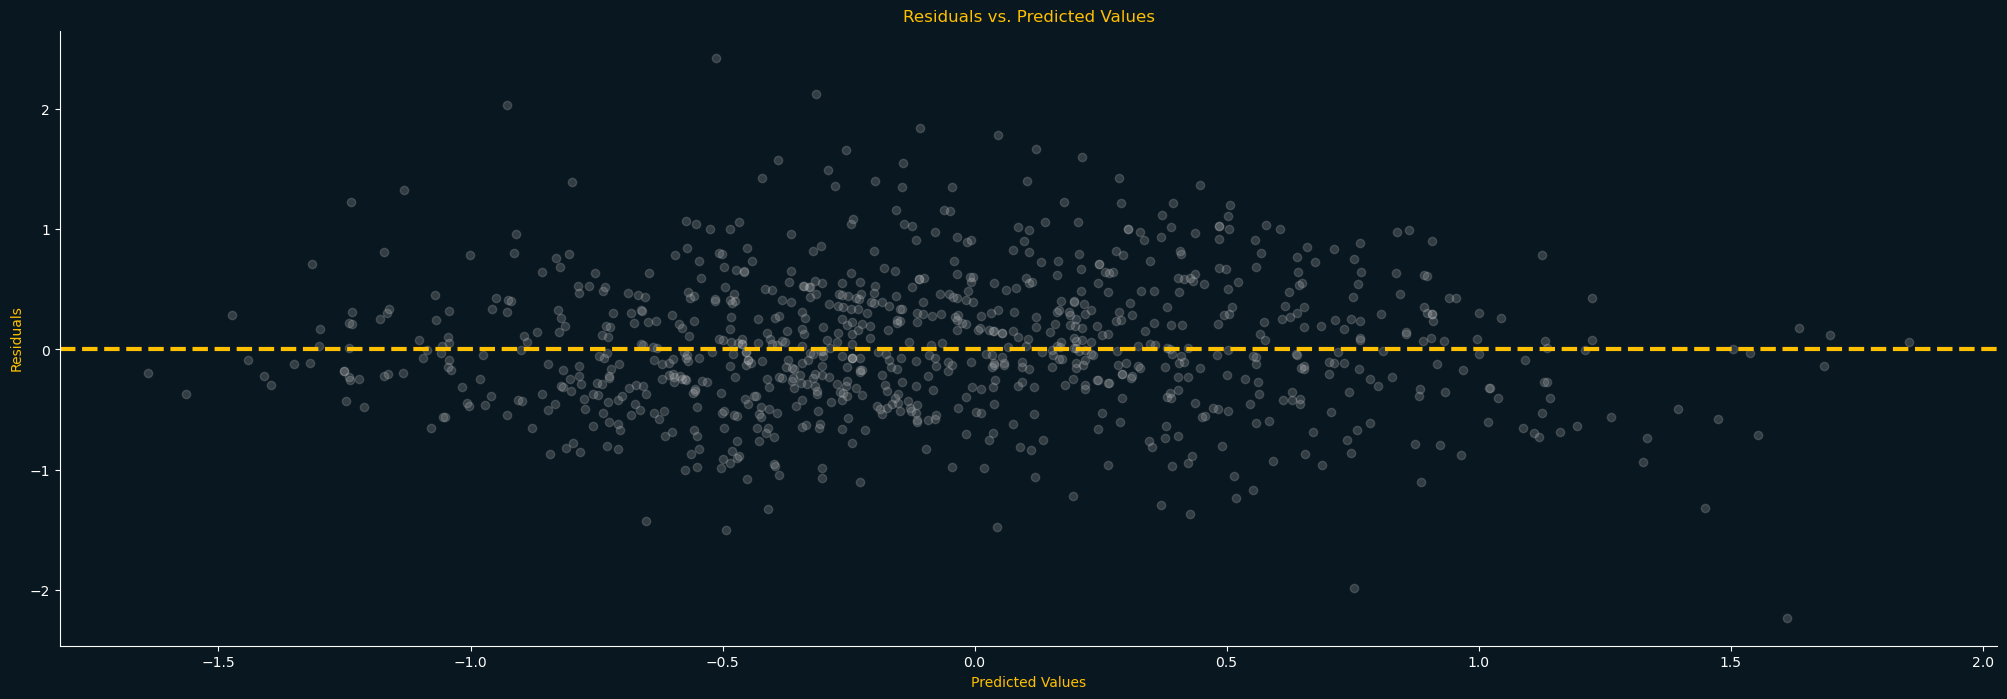

In [89]:
#Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(25, 8))
plt.scatter(y_pred, residuals, alpha=0.2, color='lightgrey')
plt.axhline(y=0, color='#FFC000', linestyle='--', linewidth=3)
plt.xlabel('Predicted Values', color='#FFC000')
plt.ylabel('Residuals', color='#FFC000')
plt.tick_params(axis='y', colors='white')
plt.tick_params(axis='x', colors='white')
plt.title('Residuals vs. Predicted Values', color='#FFC000')

plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['top'].set_color('#091720') 
plt.gca().spines['right'].set_color('#091720')
plt.gca().spines['left'].set_color('white')
plt.gca().set_facecolor('#091720')
plt.gcf().set_facecolor('#091720')

plt.show()

# Independence

In [90]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson_stat = durbin_watson(lm1.resid)
print(f"Durbin-Watson statistic: {durbin_watson_stat}")

Durbin-Watson statistic: 1.981752843189081


# Decision Tree Modeling & Comparison

In [91]:
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train_final, y_train)
dt_predictions = dt_model.predict(X_test_final)
dt_mse = mean_squared_error(y_test, dt_predictions)
dt_mae = mean_absolute_error(y_test, dt_predictions)
dt_r2 = r2_score(y_test, dt_predictions)
dt_ar2 = adj_r2_score(X_test_final, y_test, dt_predictions)

In [92]:
#unstandardizing the data
mean = public_companies['base_salary'].mean()
std = public_companies['base_salary'].std()

unstandardized_predictions = (y_pred * std) + mean
unstandardized_test        = (y_test * std) + mean
unstandardized_dt_predictions = (dt_predictions * std) + mean

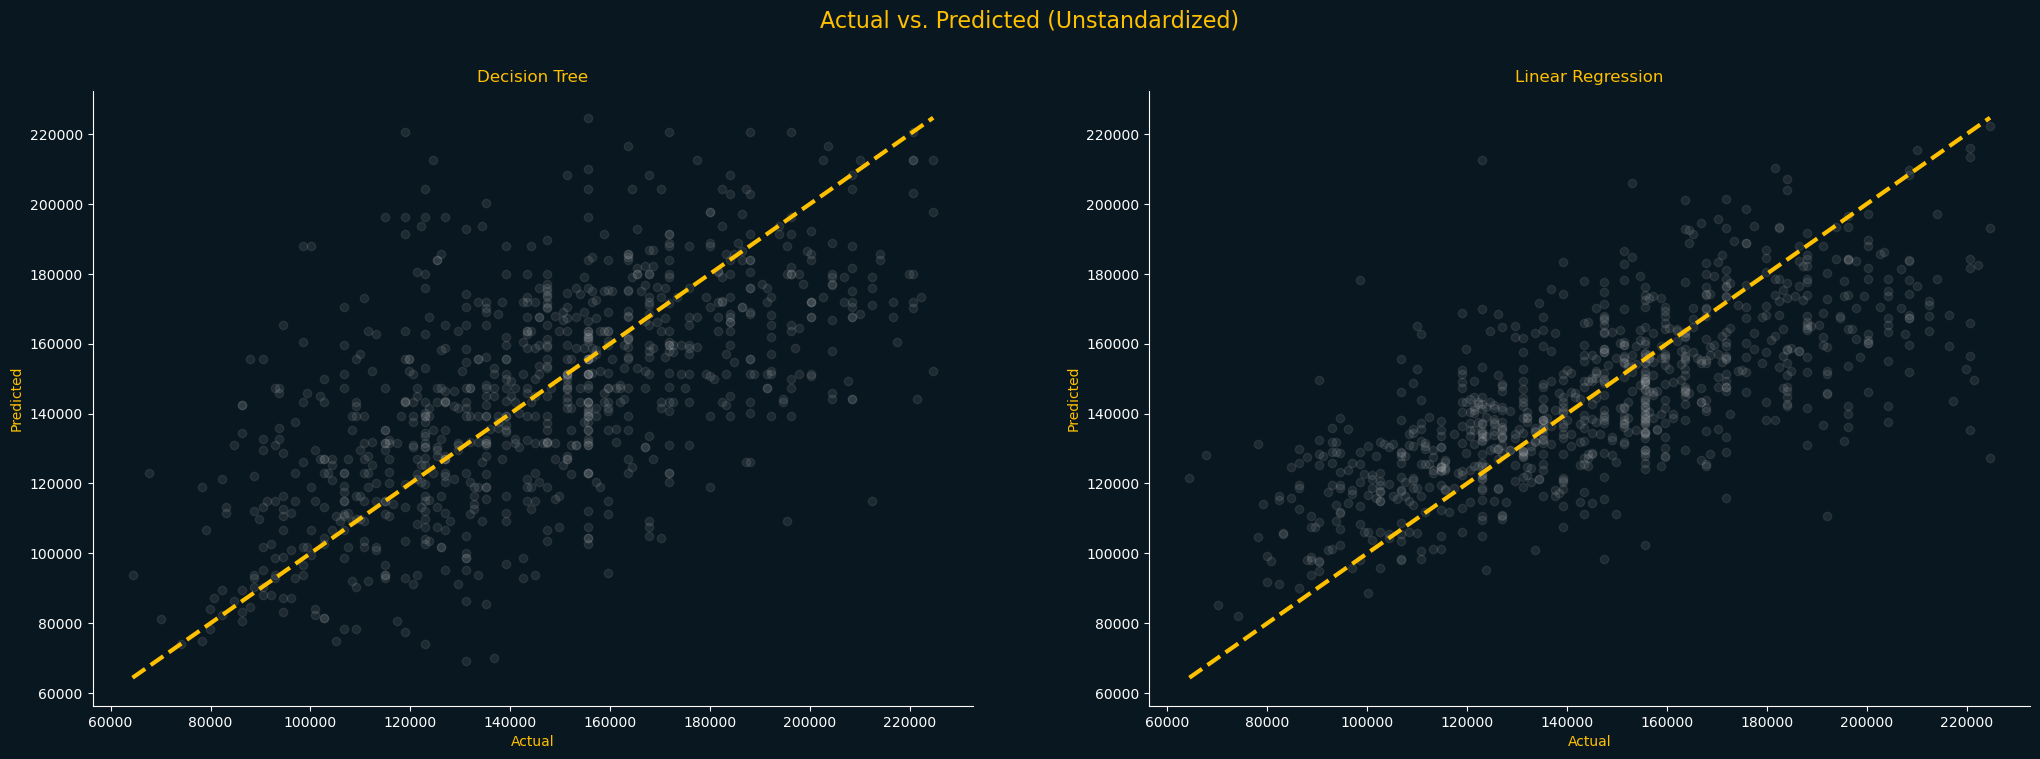

In [93]:
# plot actual vs. predicted of both models
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Actual vs. Predicted (Unstandardized)', color='#FFC000', fontsize=16)

plt.sca(ax[0])
plt.scatter(unstandardized_test, unstandardized_dt_predictions, color='lightgrey', label='Decision Tree', alpha=.1)
plt.plot([min(unstandardized_test), max(unstandardized_test)], [min(unstandardized_test), max(unstandardized_test)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Decision Tree', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')


ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

plt.sca(ax[1])
plt.scatter(unstandardized_test, unstandardized_predictions, color='lightgrey', label='Linear Regression', alpha=.1)
plt.plot([min(unstandardized_test), max(unstandardized_test)], [min(unstandardized_test), max(unstandardized_test)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Linear Regression', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

plt.show()

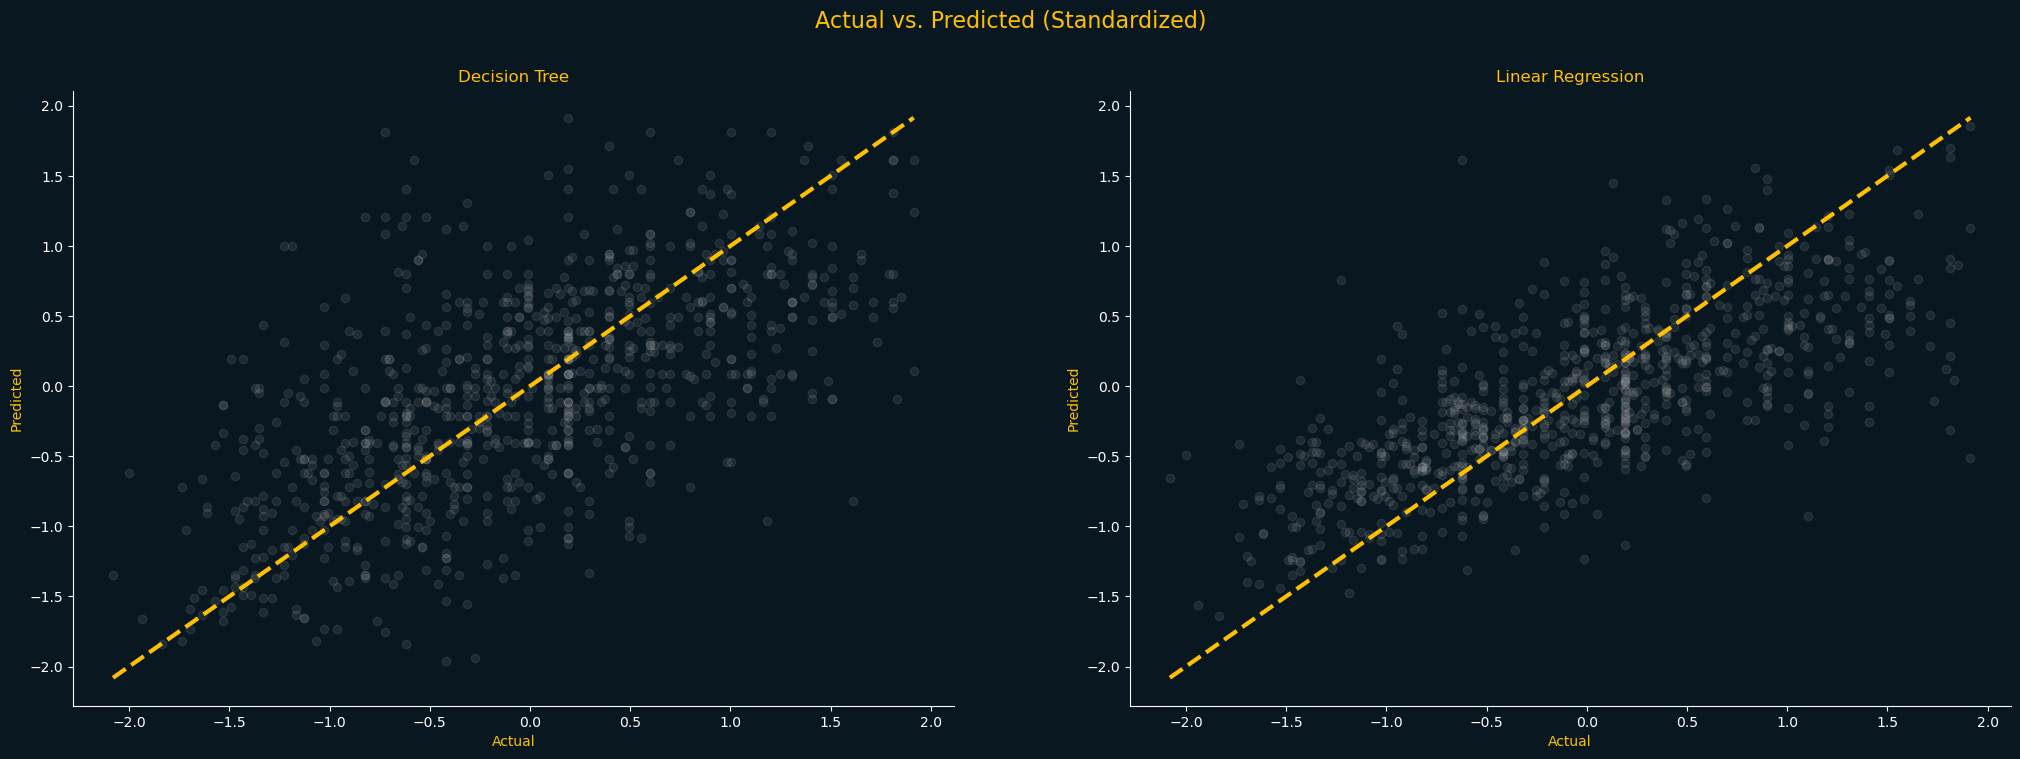

In [94]:
# plot actual vs. predicted of both models
fig, ax = plt.subplots(ncols=2)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.patch.set_facecolor('#091720')
fig.suptitle('Actual vs. Predicted (Standardized)', color='#FFC000', fontsize=16)

plt.sca(ax[0])
plt.scatter(y_test, dt_predictions, color='lightgrey', label='Decision Tree', alpha=.1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Decision Tree', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[0].tick_params(axis='y', colors='white')
ax[0].tick_params(axis='x', colors='white')


ax[0].spines['bottom'].set_color('white')
ax[0].spines['top'].set_color('#091720') 
ax[0].spines['right'].set_color('#091720')
ax[0].spines['left'].set_color('white')
ax[0].set_facecolor('#091720')

plt.sca(ax[1])
plt.scatter(y_test, y_pred, color='lightgray', label='Linear Regression', alpha=.1)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='#FFC000', linestyle='--', linewidth=3)
plt.title('Linear Regression', color='#FFC000')
plt.xlabel('Actual', color='#FFC000')
plt.ylabel('Predicted', color='#FFC000')
ax[1].tick_params(axis='y', colors='white')
ax[1].tick_params(axis='x', colors='white')

ax[1].spines['bottom'].set_color('white')
ax[1].spines['top'].set_color('#091720') 
ax[1].spines['right'].set_color('#091720')
ax[1].spines['left'].set_color('white')
ax[1].set_facecolor('#091720')

plt.show()

In [95]:
print("Decision Tree - MSE: ", dt_mse)
print("Decision Tree - MAE: ", dt_mae)
print("Linear Regression - MSE:", lr_mse)
print("Linear Regression - MAE:", lr_mae)

Decision Tree - MSE:  0.48414503504241574
Decision Tree - MAE:  0.5367142637785708
Linear Regression - MSE: 0.3313067784897206
Linear Regression - MAE: 0.4467626550763116


# Gradient Descent, Because Why Not?

In [96]:
import lab_utils_multi
from lab_utils_multi import  run_gradient_descent
from lab_utils_multi import  norm_plot, plt_equal_scale, plot_cost_i_w
from lab_utils_common import dlc

In [97]:
X_train_gd = X_train_final.drop(columns=['const']).values
y_train_gd = np.array(y_train)
X_test_gd = X_test_final.drop(columns=['const']).values
y_test_gd  = np.array(y_test)
X_features = X_train_final.drop(columns=['const']).columns.values


In [98]:
b_init = np.array([0.0])
w_init = np.zeros(X_train_gd.shape[1])

In [99]:
w_norm, b_norm, hist = run_gradient_descent(X_train_gd, y_train_gd, 1000, 1.0e-1, )

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 3.06411e-01  3.8e-02  1.6e-03  1.9e-02 -8.5e-04 -6.2e-03 -3.8e-01 -1.6e-02 -1.9e-01  8.5e-03  6.2e-02
      100 1.54415e-01  4.9e-01 -1.2e-01  3.2e-01  1.6e-01 -5.3e-02 -1.3e-04  1.1e-02  1.2e-03 -1.2e-02  3.4e-03
      200 1.49594e-01  4.9e-01 -2.1e-01  3.0e-01  2.4e-01 -9.3e-02  4.6e-07  7.9e-03  1.0e-03 -5.5e-03  4.1e-03
      300 1.47996e-01  4.9e-01 -2.8e-01  3.0e-01  2.8e-01 -1.3e-01  9.5e-06  6.0e-03  5.3e-04 -3.2e-03  3.8e-03
      400 1.47142e-01  4.9e-01 -3.3e-01  2.9e-01  3.1e-01 -1.7e-01  1.2e-05  4.7e-03  2.6e-04 -2.2e-03  3.5e-03
      500 1.46550e-01  4.9e-01 -3.7e-01  2.9e-01  3.3e-01 -2.0e-01  1.3e-05  3.7e-03  1.2e-04 -1.8e-03  3.2e-03
      600 1.46090e-01  4.9e-01 -4.1e-01  2.9e-01  3.5e-01 -2.3e-01  1.5e-05  3.0e-03  4.6e-05 -1.6e-03  

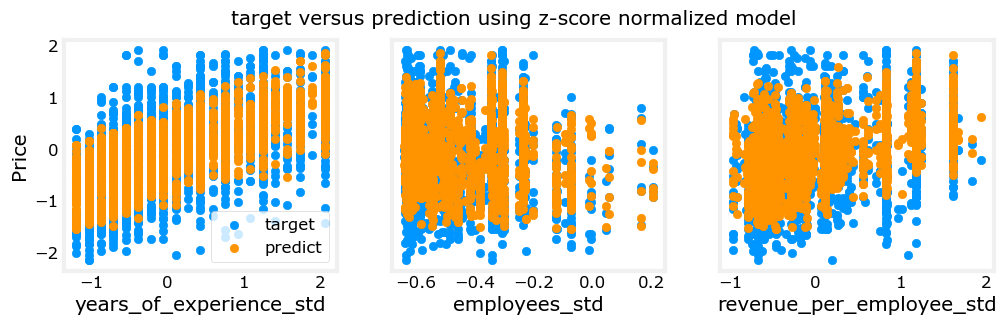

In [100]:
m = X_train_gd.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_train_gd[i], w_norm) + b_norm

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,3,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train_gd[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train_gd[:,i],yp,color=dlc["dlorange"], label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

In [101]:
y_pred_gd = np.dot(X_test_gd, w_norm) + b_norm
gd_mse = mean_squared_error(y_test_gd, y_pred_gd)
gd_mae = mean_absolute_error(y_test_gd, y_pred_gd)
gd_r2 = r2_score(y_test_gd, y_pred_gd)
gd_ar2 = adj_r2_score(X_test_gd, y_test_gd, y_pred_gd)

In [102]:
print('Gradient Descent    MSE: ' + str(gd_mse.round(2)))
print('                    MAE: ' + str(gd_mae.round(2)))
print('                    r^2: ' + str(gd_r2.round(2)))
print('                   ar^2: ' + str(gd_ar2.round(2)))
print("Decision Tree       MSE: " + str(dt_mse.round(2)))
print("                    MAE: " + str(dt_mae.round(2)))
print('                    r^2: ' + str(dt_r2.round(2)))      
print('                   ar^2: ' + str(dt_ar2.round(2)))      
print("Linear Regression   MSE: " + str(lr_mse.round(2)))
print("                    MAE: " + str(lr_mae.round(2)))
print('                    r^2: ' + str(lr_r2.round(2)))
print('                   ar^2: ' + str(lr_ar2.round(2)))

Gradient Descent    MSE: 0.33
                    MAE: 0.45
                    r^2: 0.51
                   ar^2: 0.51
Decision Tree       MSE: 0.48
                    MAE: 0.54
                    r^2: 0.29
                   ar^2: 0.28
Linear Regression   MSE: 0.33
                    MAE: 0.45
                    r^2: 0.56
                   ar^2: 0.56


In [103]:
w_norm, b_norm, hist = run_gradient_descent(X_train_gd, y_train_gd, 3000, 9.0e-2, )

Iteration Cost          w0       w1       w2       w3       b       djdw0    djdw1    djdw2    djdw3    djdb  
---------------------|--------|--------|--------|--------|--------|--------|--------|--------|--------|--------|
        0 3.08463e-01  3.4e-02  1.5e-03  1.7e-02 -7.6e-04 -5.6e-03 -3.8e-01 -1.6e-02 -1.9e-01  8.5e-03  6.2e-02
      300 1.48356e-01  4.9e-01 -2.6e-01  3.0e-01  2.7e-01 -1.2e-01  7.9e-06  6.5e-03  6.5e-04 -3.7e-03  3.9e-03
      600 1.46354e-01  4.9e-01 -3.9e-01  2.9e-01  3.4e-01 -2.1e-01  1.4e-05  3.4e-03  8.3e-05 -1.7e-03  3.0e-03
      900 1.45362e-01  4.9e-01 -4.6e-01  2.9e-01  3.8e-01 -2.9e-01  1.9e-05  1.9e-03 -8.0e-06 -1.4e-03  2.3e-03
     1200 1.44696e-01  4.9e-01 -4.9e-01  2.9e-01  4.1e-01 -3.4e-01  2.3e-05  1.1e-03 -1.6e-05 -1.2e-03  1.8e-03
     1500 1.44211e-01  4.9e-01 -5.2e-01  2.9e-01  4.4e-01 -3.8e-01  2.4e-05  6.1e-04 -1.2e-05 -1.1e-03  1.4e-03
     1800 1.43843e-01  4.9e-01 -5.3e-01  2.9e-01  4.7e-01 -4.2e-01  2.4e-05  3.6e-04 -7.5e-06 -9.8e-04  

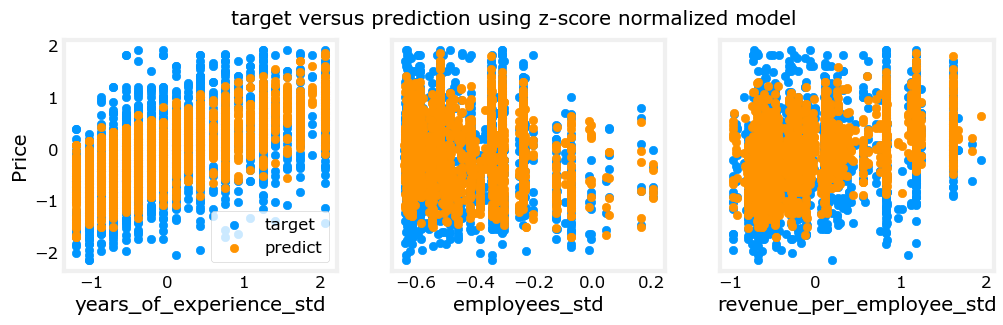

In [104]:
m = X_train_gd.shape[0]
yp = np.zeros(m)
for i in range(m):
    yp[i] = np.dot(X_train_gd[i], w_norm) + b_norm

    # plot predictions and targets versus original features    
fig,ax=plt.subplots(1,3,figsize=(12, 3),sharey=True)
for i in range(len(ax)):
    ax[i].scatter(X_train_gd[:,i],y_train, label = 'target')
    ax[i].set_xlabel(X_features[i])
    ax[i].scatter(X_train_gd[:,i],yp,color=dlc["dlorange"], label = 'predict')
ax[0].set_ylabel("Price"); ax[0].legend();
fig.suptitle("target versus prediction using z-score normalized model")
plt.show()

In [105]:
y_pred_gd = np.dot(X_test_gd, w_norm) + b_norm
gd_mse = mean_squared_error(y_test_gd, y_pred_gd)
gd_mae = mean_absolute_error(y_test_gd, y_pred_gd)
gd_r2 = r2_score(y_test_gd, y_pred_gd)
gd_ar2 = adj_r2_score(X_test_gd, y_test_gd, y_pred_gd)

In [106]:
print('Gradient Descent    MSE: ' + str(gd_mse.round(2)))
print('                    MAE: ' + str(gd_mae.round(2)))
print('                    r^2: ' + str(gd_r2.round(2)))
print('                   ar^2: ' + str(gd_ar2.round(2)))
print("Decision Tree       MSE: " + str(dt_mse.round(2)))
print("                    MAE: " + str(dt_mae.round(2)))
print('                    r^2: ' + str(dt_r2.round(2)))      
print('                   ar^2: ' + str(dt_ar2.round(2)))      
print("Linear Regression   MSE: " + str(lr_mse.round(2)))
print("                    MAE: " + str(lr_mae.round(2)))
print('                    r^2: ' + str(lr_r2.round(2)))
print('                   ar^2: ' + str(lr_ar2.round(2)))

Gradient Descent    MSE: 0.33
                    MAE: 0.45
                    r^2: 0.52
                   ar^2: 0.51
Decision Tree       MSE: 0.48
                    MAE: 0.54
                    r^2: 0.29
                   ar^2: 0.28
Linear Regression   MSE: 0.33
                    MAE: 0.45
                    r^2: 0.56
                   ar^2: 0.56
